# Data Preparation 
Created by Keenan McConkey 2019.8.12, edited by Mahsa Khalili 2021.01.08

- **Import notebook dependencies**
- **Defining notebook variables**
- **Defining notebook parameters **
- **Importing IMU data (i.e., raw IMU data collected from the DAQ modules mounted to the wheelchair frame**
    - A total of 84 datasets are imported: measurements are from 4 users (three maneuvrs each) and 7 indoor/outdoor terrains
- **Visualizing imported data & comparing kinematic characteristics across different terrains**
- **Functions to convert between pandas & numpy**
- **Signal processing**
    - Filtering IMU data 
    - Visualizing & comparing raw and filtered data
    - Trim stationary data (noMotion_dataset) & update filt_datasets dic (non-stationary data only)
    - Update filtered dataframe including no-motion dataset
- **Slicing & Windowing dataframes**
- **FFT/PSD**
- **Feature enginering**
- **Columning, combining features, adding labels**
    - include no motion dataframes
- **Visualizing extracted features**
- **Export dataframes to csv**

### Import dependencies

In [1]:
# Import relevant modules
import os
import glob
import time
from datetime import datetime

import pandas as pd
import numpy as np

import random
from random import randrange
from scipy.fft import fft, fftfreq
from scipy.signal import sosfiltfilt, butter, welch

import matplotlib.pyplot as plt
from matplotlib import gridspec

from joblib import dump, load

### Notebook Variables

In [2]:
# Import data
# Importing which user's data ['All', 'Jamie', 'Keenan', 'Kevin', 'Mahsa']
# USER = 'All' 
USER = 'All'

# Which measurements to import ['Manual', 'Power', 'Remote']
POWER_TYPE = 'Power' 

# number of datapoints in each segment 
## good practice for fft analysis: better to have a value that's a power of 2
SAMP_SLICE = 1024 

# filter parameters
CUT_OFF = 20 # lowpass cut-off frequency (Hz) 

# whether to create test or train dataset (if test true: create test dataset otherwise create train dataset)
TEST = True

# Whether to export data (set to false when testing the code)
EXPORT_PROCESSED_DATA = False 

### Notebook Parameters (Constant values)

In [3]:
# renamed column names (easier to read column names)
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro'] # removing time-related columns

# Columns not currently used for classification
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ', 'ACCELEROMETER XY (m/s²)']

# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD_welch']
movements = ['F8', 'Donut', 'Straight']

# gravitional acceleration on flat surface
Gz = 9.81 

# sampling frequency
f_samp_9250 = 100 # 9250's frame's module
f_samp_6050 = 300 # 6050's frame's module
f_samp_wheels = 333 # wheels' modules (not used for PAPAW data)

## Part 1 - Importing IMU measurements

### 1.1. Defining datasets' directory: currently importing frame's 6050 IMU measurement for PAPAW

In [4]:
# Power and manual data stored in separate folders
if POWER_TYPE == 'Manual':
    power_type_folder = 'set_manual'
elif POWER_TYPE == 'Power':
    power_type_folder = 'set_power'
elif POWER_TYPE == 'Remote':
    power_type_fodler = 'set_remote'
else:
    raise Exception('Unknown power type!')

# Relative path of this notebook
CURR_PATH = os.path.abspath('.')
    
# Glob all csv files in the folder
glob_paths = glob.glob(os.path.join(CURR_PATH, 'imu_data', power_type_folder, '*.csv'))

# Remove 9250 9-axis IMU data (for now)
glob_paths = [path for path in glob_paths if '9250' not in path]

# Keenan is "default" user so files without any username are assumed to be his
## Will update this later
if USER == 'All':
    dataset_paths = glob_paths
elif USER == 'Keenan' or USER == 'Mahsa' or USER == 'Kevin' or USER == 'Jamie':
    dataset_paths = [path for path in glob_paths if 'Mahsa' not in path]
else:
    raise Exception('Unknown user!')

In [6]:
''' new approach to create a homogenous & separate train/test datasets '''

random.seed(0)

# select test datasets
test_dataset_paths = []
for user in ['Jamie', 'Keenan', 'Kevin', 'Mahsa']:
    for terrain in terrains:
        maneuver = movements[randrange(3)]
        path_name = os.path.join(CURR_PATH, 'imu_data', power_type_folder) +'\Middle_' + terrain+ 'Power' + maneuver + user + '_Module6050.csv'
        test_dataset_paths.append(path_name)
        
# select train datasetes
train_dataset_paths = [path for path in glob_paths if path not in test_dataset_paths]

['C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\imu_data\\set_power\\Middle_ConcretePowerDonutJamie_Module6050.csv',
 'C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\imu_data\\set_power\\Middle_CarpetPowerDonutJamie_Module6050.csv',
 'C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\imu_data\\set_power\\Middle_LinoleumPowerF8Jamie_Module6050.csv',
 'C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\imu_data\\set_power\\Middle_AsphaltPowerDonutJamie_Module6050.csv',
 'C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\imu_data\\set_power\\Middle_SidewalkPowerStraightJamie_Module6050.csv',
 'C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\imu_data\\set_power\\Middle_GrassPowerDonutJamie_Module6050.csv',
 'C:\\Users\\CARIS\\Google Drive\\UBC\\PhD\\Terrain Classification\\PythonScripts\\imu_data\\s

### 1.2. Parsing data into Pandas

In [8]:
# Import datasets as a dictionary of Pandas DataFrames

raw_datasets = {} # creating an empty dictionary to store all dataframes

if TEST:
    DATASET_PATHS = test_dataset_paths
else:
    DATASET_PATHS = train_dataset_paths

## To analyze data from the train_dataset_paths only
for dataset_path in DATASET_PATHS:
    
    # Parse labels from filenames
    dataset_label = os.path.split(dataset_path)[1].split('.')[0]    

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to easier to work with names
    dataset.columns = std_columns.copy()

    # Convert timestamps to epoch time in sec
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle frame data
    ## Can't remove from wheel-mounted Left and Right wheel data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - Gz)
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [9]:
# Sort dictionary according to keys
raw_datasets = {label: raw_datasets[label] for label in sorted(raw_datasets.keys())}

# Save list of keys to variable
dataset_labels = list(raw_datasets.keys())
print('The total number of imported datasets: {}'.format(len(dataset_labels)))

The total number of imported datasets: 28


In [10]:
# Check dataset formatting
print('sample data from the "{}" measurements '.format(dataset_labels[0]))
raw_datasets[dataset_labels[0]].head()

sample data from the "Middle_AsphaltPowerDonutJamie_Module6050" measurements 


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
0 -0.430602  0.296587 -0.057219 -0.002924 -0.004884  0.007945  0.000000   
1 -0.284523  0.337298  0.028992 -0.002657 -0.003552  0.014870  0.003145   
2 -0.277338  0.315745 -0.033271  0.003203 -0.001688  0.005547  0.006171   
3 -0.325233  0.184034 -0.002140 -0.004788 -0.008347  0.005281  0.009993   
4 -0.387497  0.287008 -0.062008 -0.005854 -0.008613  0.006080  0.013119   

     Epoch Time  
0  1.565211e+09  
1  1.565211e+09  
2  1.565211e+09  
3  1.565211e+09  
4  1.565211e+09

## Part 2 - Visualizing Time Domain Data

### 2.1. Plotting functions: plot a single Pandas dataset for a given x and y axes

In [11]:
def plot_one_dataframe(_datasets, dataset_name, x_axis, y_axes, xlim=None, ylim=None, save_fig=False):
    
    '''Plot a single Pandas dataframe for a given x axis (e.g., time) and one/multiple y axes (e.g., x_acceleration)'''
    
    def create_y_label(y_axes):
        y_axis = ''

        for y_ax in y_axes:
            if y_axis != '':
                y_axis += ', '
            y_axis += y_ax  

        # Add relevant units to y label
        if 'Accel' in y_axis:
            y_label = y_axis + ' ($m/s^2$)'
        elif 'Gyro' in y_axis:
            y_label = y_axis + ' ($rad/s$)'
        elif 'Vel' in y_axis:
            y_label = y_axis + ' ($m/s$)'
        else:
            y_label = y_axis
            
        return(y_label)
    
    # create y label from the input list of y_axes
    y_label = create_y_label(y_axes)
    
    plt.figure(figsize=(10, 5))
    
    # Plot relevant data
    for y_axis in y_axes:
        plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis], label=y_axis)
    
    # add relevant info to the graphs
    plt.title(dataset_name)
    plt.legend()
    plt.xlabel(x_axis + ' (s)')
    plt.ylabel(y_label)
    
    # Use limits if they've been passed in
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1]) 
        
    plt.show()

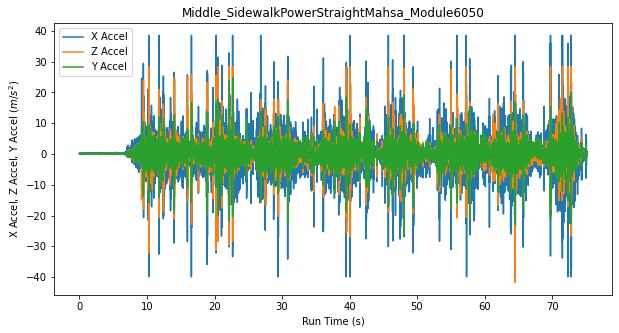

In [12]:
plot_one_dataframe(raw_datasets, dataset_labels[-1], 'Run Time', ['X Accel', 'Z Accel', 'Y Accel'], save_fig = False)

### 2.2. Plotting functions: Compare two Pandas datasets by Run Time

In [13]:
def dataset_compare(dataset1, label1, dataset2, label2, y_axis, t_offset=0, y_offset=0, trim=False, Filtered = False):
    
    '''Plot and compare one-axis measurement (e.g., X-accel) of two Pandas datasets over Run Time'''
    
    # number of datapoints to display for a filtered dataset (currently equal to 1 window size)
    trim_offset = SAMP_SLICE 

    # Plot parameters
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_xlabel('Run Time ($s$)')
    ax.set_title(y_axis + ' for ' + label1 + ' and ' + label2)
        
    # Add relevant units to y label
    if 'Gyro' in y_axis:
        ax.set_ylabel(y_axis + ' ($rad/s$)')
    elif 'Accel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s^2$)')
    elif 'Vel' in y_axis:
        ax.set_ylabel(y_axis + ' ($m/s$)')
    else:
        ax.set_ylabel('Unknown')
    
    # determine whether plotting filtered or raw data
    if Filtered:
        legend1= label1 + '_raw'
        legend2= label2 +'_filtered'
    else:
        legend1 = label1
        legend2 = label2
   
    # remove extra text in the labels
    legend1 = legend1.replace('Middle_','').replace('_Module6050','')
    legend2 = legend2.replace('Middle_','').replace('_Module6050','')
    
    # Plot data with given y and t offsets applied to first dataset
    if trim:
        ax.plot(dataset1[label1]['Run Time'][:trim_offset].apply(lambda t: t + t_offset), 
            dataset1[label1][y_axis][:trim_offset].apply(lambda y: y + y_offset), label=legend1)
        ax.plot(dataset2[label2]['Run Time'][:trim_offset], 
            dataset2[label2][y_axis][:trim_offset], label=legend2)
        
    else:
        ax.plot(dataset1[label1]['Run Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][y_axis].apply(lambda y: y + y_offset), label=legend1)
        ax.plot(dataset2[label2]['Run Time'], 
            dataset2[label2][y_axis], label=legend2)
    
    # Include offset info text in plot
#     offset_text = 'Offsets\n'
#     offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
#     ax.text(0.05, 0.05, s=offset_text, 
#             horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

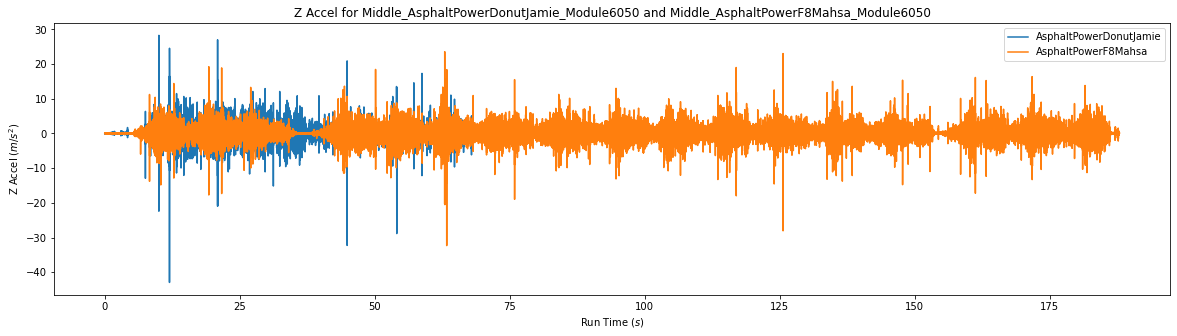

In [14]:
# Compare Z Gyro data for two dataframes
dataset_compare(raw_datasets, dataset_labels[0],
               raw_datasets, dataset_labels[1], y_axis='Z Accel', t_offset=0)

### 2.3. Plotting functions: Plot given x and y axes for every Pandas DataFrame in given array of datasets

In [15]:
def plot_selected_datasets(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):

    '''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''

    # Set paramaeters based on number of datasets to plot
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 0
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
    axes = []
    row, col = 0, 0
    
    # Plot each of the given datasets
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

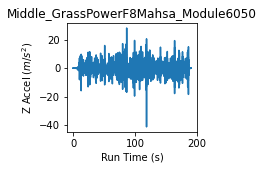

In [16]:
# Plot Z Accel of selected datasets
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() 
                    if 'Middle' in label and 'Grass' in label and 'F8' in label}
plot_selected_datasets(datasets_to_plot, x_axis='Run Time', y_axis='Z Accel')

### 2.4. Plotting functions: Plot a selected axis of all datasets

In [17]:
def plot_all_OneAxis(datasets, axis):
    
    '''plotting one axis (e.g., X Accel) measurement of all dataframes '''
    
    if USER == 'All':
        ncol = 4 # N of participants
    else:
        ncol = 1 # N of participants
    
    nrow = int(len(datasets)/ncol)

    fig, axs = plt.subplots(nrow, ncol, sharey=True, figsize=(20,50))
    fig.tight_layout()
    
    axs = axs.ravel()

    for i, (label, dataset) in enumerate(datasets.items()):
        axs[i].plot(dataset[axis])
        axs[i].set_title(label.replace('Middle_','').replace('_Module6050',''))
    
    fig.text(-.01, 0.5, 'Acceleration: X-axis ${(m/s^2)}$', va='center', rotation='vertical', fontsize = 20)

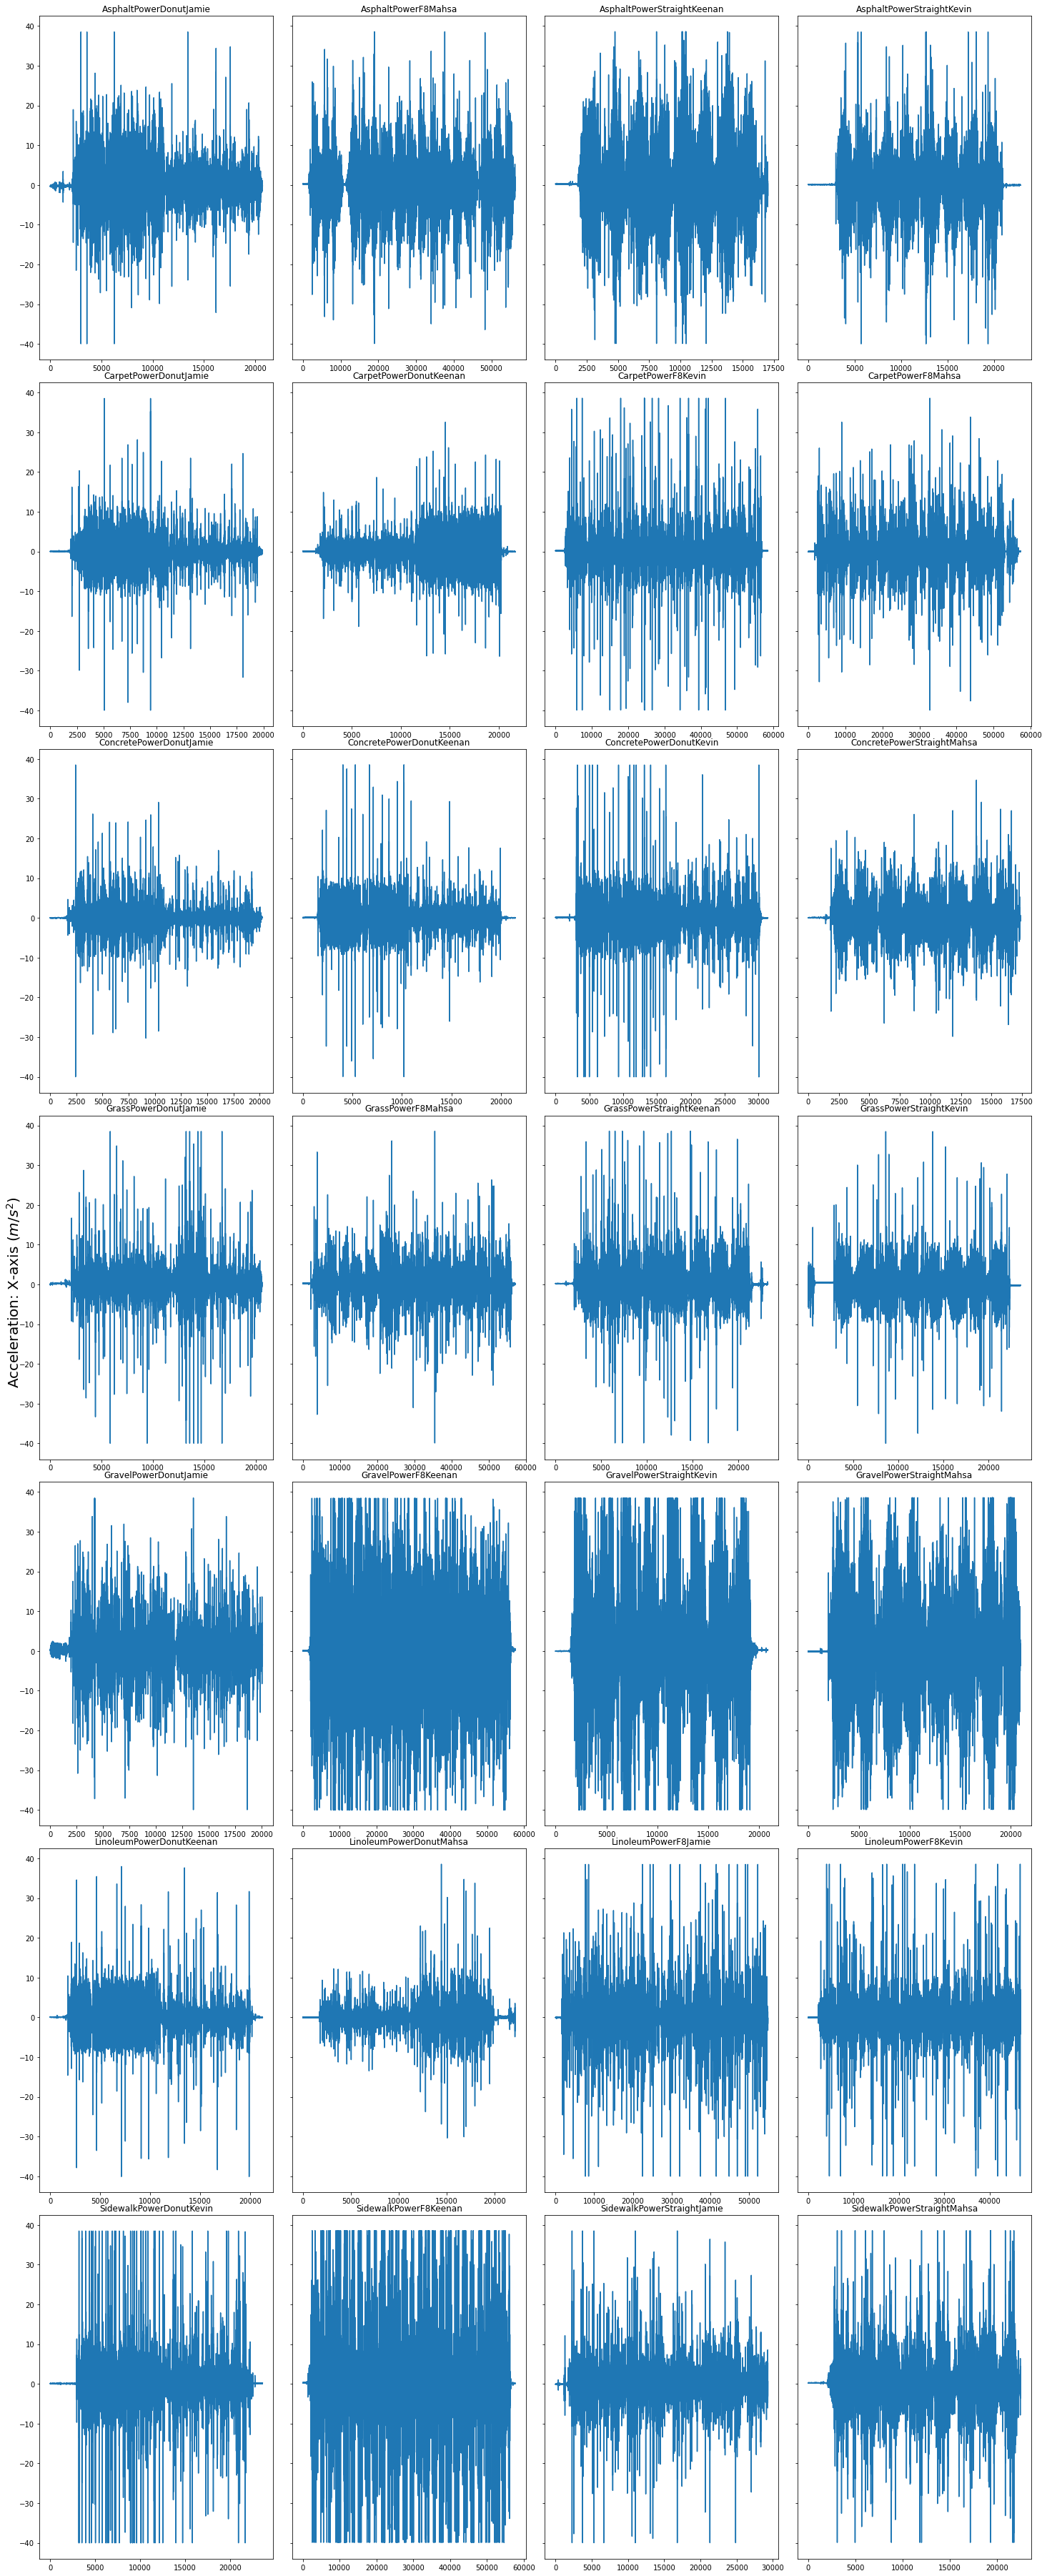

In [18]:
plot_all_OneAxis(raw_datasets, axis = 'X Accel')

## Part 3 - Converting Between Pandas and Numpy

In [19]:
def pd_to_np(pd_datasets, windowed=False):
    
    '''Convert array of Pandas DataFrames to array of 2D NumPy array'''

    np_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                
                # MK edited, based on this link: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.as_matrix.html
                np_dataset.append(window.to_numpy())  
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [20]:
def np_to_pd(np_datasets, windowed=False):
    
    '''Convert array of 2D NumPy arrays to Pandas Data Frames'''

    pd_datasets = {}
    
    # Convert each dataset individually
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = std_columns.copy()
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))     
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [21]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [22]:
# Run to convert back to Pandas
raw_datasets = np_to_pd(raw_datasets)

In [23]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[4]].shape))

Number of datasets: 28
Shape of first dataset: (19912, 8)


## Part 4 - Signal processing

### 4.1. Butterworth Filter
#### 4.1.1. Function to set appropriate cut-off frequency for butterworth filter

In [24]:
def get_frequencies(label):
    
    '''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''

    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    ## Currently not using high pass frequency
    if 'Left' in label or 'Right' in label:
        f_samp = f_samp_wheels 
        f_low = CUT_OFF 
        f_high = 1 
        
    elif 'Middle' in label:
        f_samp = f_samp_6050 # Sampling frequency
        f_low = CUT_OFF # a list of cutoff frequency starting at 20Hz
        f_high = 1 # High pass cutoaff frequency
        
    else:
        raise Exception('Unknown label')
        
    return f_samp, f_low, f_high

#### 4.1.2. Implementing a 4th-order butterworth filter & creating a new dictionary with filtered dataframes

In [25]:
# Filtered datasets dictionary
filt_datasets = {}

# Filter each dataset individually
for label, raw_dataset in raw_datasets.items():
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Nyquist frequecy
    nyq = 0.5 * f_samp 
    
    # Get normalized frequencies 
    w_low = f_low / nyq 

    # Get Butterworth filter parameters (numerator and denominator)
    ## The function sosfiltfilt (and filter design using output='sos') should be preferred over filtfilt for most 
    ## filtering tasks, as second-order sections have fewer numerical problems.
    sos = butter(N=2, Wn=w_low, btype='low', output='sos')
    
    # Number of columns containing data
    n_data_col = len(data_columns)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    
    for i in range(n_data_col):
        
        # Apply a digital filter forward and backward to a signal.
        ## The combined filter (filtfilt) has zero phase and a filter order twice that of the original.
        dataset[:, i] = sosfiltfilt(sos, dataset[:, i])
        
    filt_datasets.update({label: dataset})
#     filt_datasets.update({label: dataset[5:-5,:]})

In [26]:
# Check construction of filtered dataset
print('Num filtered datasets: {}'.format(len(filt_datasets)))
print('Shape of first filtered dataset: {}'.format(filt_datasets[dataset_labels[1]].shape))

Num filtered datasets: 28
Shape of first filtered dataset: (56323, 8)


In [27]:
# Verify we can convert back to Pandas
display(np_to_pd(filt_datasets, windowed=False)[dataset_labels[0]].head())
display(raw_datasets[dataset_labels[0]].head())

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
0 -0.434498  0.296481 -0.057961 -0.002863 -0.004867  0.007957  0.000000   
1 -0.404739  0.295571 -0.051327 -0.002712 -0.004974  0.007413  0.003145   
2 -0.378751  0.295095 -0.046052 -0.002631 -0.005101  0.006787  0.006171   
3 -0.358389  0.295783 -0.042593 -0.002644 -0.005231  0.006055  0.009993   
4 -0.343096  0.298023 -0.040307 -0.002725 -0.005324  0.005230  0.013119   

     Epoch Time  
0  1.565211e+09  
1  1.565211e+09  
2  1.565211e+09  
3  1.565211e+09  
4  1.565211e+09

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
0 -0.430602  0.296587 -0.057219 -0.002924 -0.004884  0.007945  0.000000   
1 -0.284523  0.337298  0.028992 -0.002657 -0.003552  0.014870  0.003145   
2 -0.277338  0.315745 -0.033271  0.003203 -0.001688  0.005547  0.006171   
3 -0.325233  0.184034 -0.002140 -0.004788 -0.008347  0.005281  0.009993   
4 -0.387497  0.287008 -0.062008 -0.005854 -0.008613  0.006080  0.013119   

     Epoch Time  
0  1.565211e+09  
1  1.565211e+09  
2  1.565211e+09  
3  1.565211e+09  
4  1.565211e+09

In [28]:
filt_datasets = np_to_pd(filt_datasets)

<Figure size 432x288 with 0 Axes>

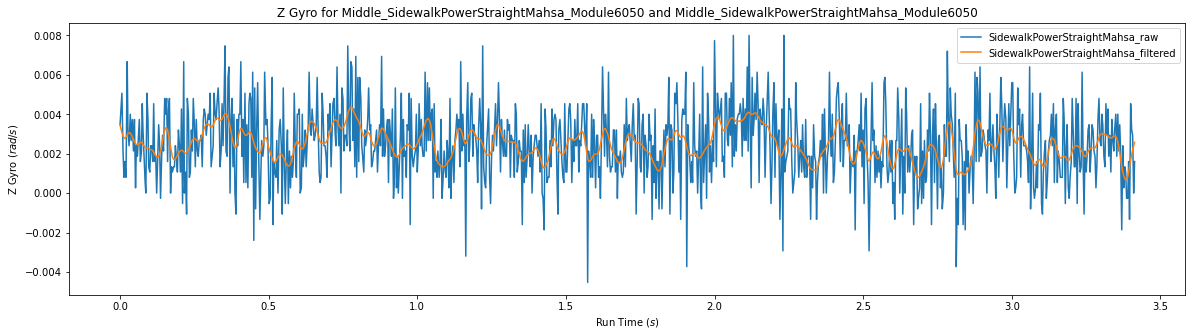

In [29]:
# compare a segment of filtered and unfiltered data
dataset_compare(raw_datasets, dataset_labels[-1], 
                filt_datasets, dataset_labels[-1], 'Z Gyro', trim = True, Filtered = True)

<Figure size 432x288 with 0 Axes>

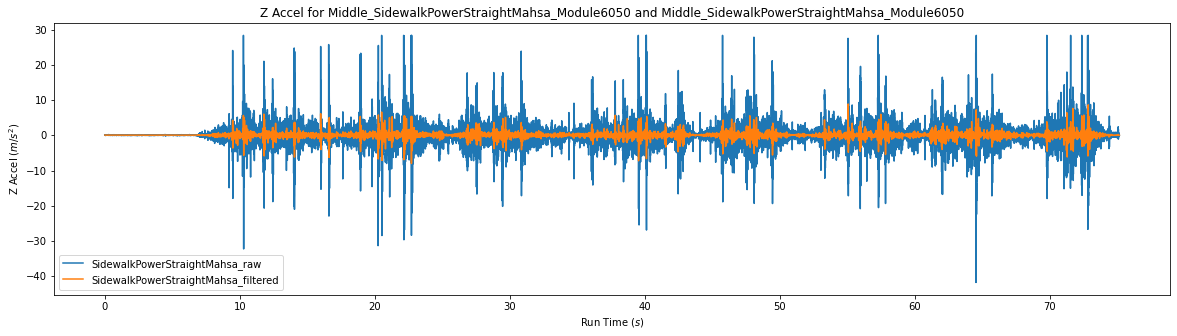

In [30]:
# compare filtered and unfiltered data
dataset_compare(raw_datasets, dataset_labels[-1], filt_datasets, dataset_labels[-1],
                         'Z Accel', Filtered = True)

### 4.2. Create a no-motion dataframe

In [31]:
'''extract no-motion data from all datafames'''
def create_noMotion_dataset(datasets):

    noMotion_datasets = {}
    
    # axis to use as a reference
    thresh_axes = 'X Accel' # this is more representative of the state of motion rather than z acceleration
    
    # start/stop threshold of motion for raw & filtered data
    NOMOTION_STOP_THRESH = 1.5
    
    # no-motion data 
    for label, dataset in datasets.items():
        
        # correct one of measurements
        if  'Grass' in label and 'Straight' in label and 'Kevin' in label:
            stop_index = 0
            
        else:
            # Caluclate first instance below threshold and use as the time domain               
            stop_index = dataset[dataset[thresh_axes] > NOMOTION_STOP_THRESH].index[0]
        
        dataset = dataset[:stop_index]
        
        noMotion_datasets.update({label:dataset})

    # concatenating the DataFrames
    df = pd.concat(noMotion_datasets.values(), ignore_index=True)
    
    return noMotion_datasets, df

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  Run Time  \
0 -0.434498  0.296481 -0.057961 -0.002863 -0.004867  0.007957  0.000000   
1 -0.404739  0.295571 -0.051327 -0.002712 -0.004974  0.007413  0.003145   
2 -0.378751  0.295095 -0.046052 -0.002631 -0.005101  0.006787  0.006171   
3 -0.358389  0.295783 -0.042593 -0.002644 -0.005231  0.006055  0.009993   
4 -0.343096  0.298023 -0.040307 -0.002725 -0.005324  0.005230  0.013119   

     Epoch Time  
0  1.565211e+09  
1  1.565211e+09  
2  1.565211e+09  
3  1.565211e+09  
4  1.565211e+09

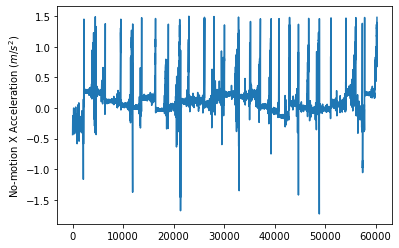

In [32]:
# obtain no-motion data in the form of a dictionary & dataset
noMotion_datasets, noMotion_dataset = create_noMotion_dataset(filt_datasets)

# plot no-motion data
plt.plot(noMotion_dataset['X Accel'])
plt.ylabel('No-motion X Acceleration $(m/s^2)$')

# examine no-motion dataset
noMotion_dataset.head()

### 4.3. Update all dataframe and remove no-motion data

In [33]:
def trim_data(datasets):
    
    '''
    function to remove stationary data from all dataframes
    this function was tuned using visual inspection of trimed output
    '''
    
    trim_datasets = {}
    
    # axis to use as a reference
    thresh_axes = 'X Accel' # this is more representative of the state of motion rather than z acceleration
    
    # start/stop threshold of motion for raw & filtered data
    STARTUP_THRESH_FILT = 1.5 
    STOP_THRESH_FILT = 0.0
    
    # get non-stationary signal 
    for label, dataset in datasets.items():
        
        # correct one of measurements
        if 'Grass' in label and 'Straight' in label and 'Kevin' in label:
            dataset = dataset.iloc[300:]
        
        # Caluclate first and last instance above threshold and use as the time domain
        start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH_FILT].index[0]               
        stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH_FILT].index[-1]
        dataset = dataset[start_index:stop_index]
        
        trim_datasets.update({label:dataset})
    
    return trim_datasets

In [34]:
# create a dictionary of dataframes with motion datasets only
all_datasets = trim_data(filt_datasets)

<Figure size 432x288 with 0 Axes>

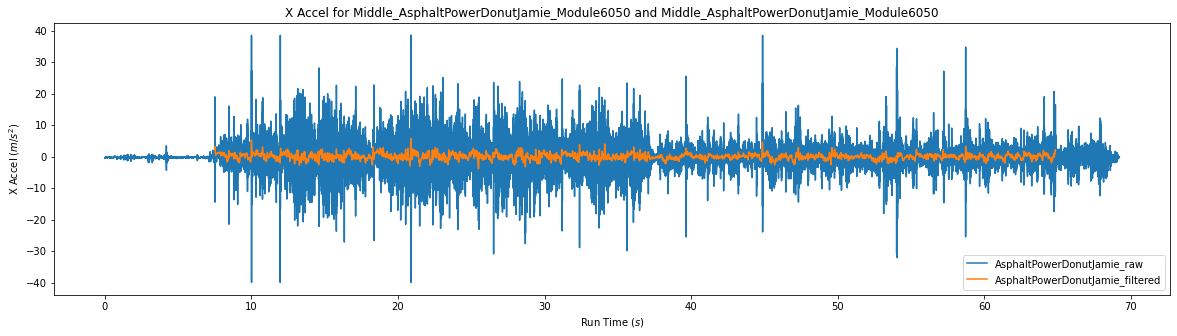

<Figure size 432x288 with 0 Axes>

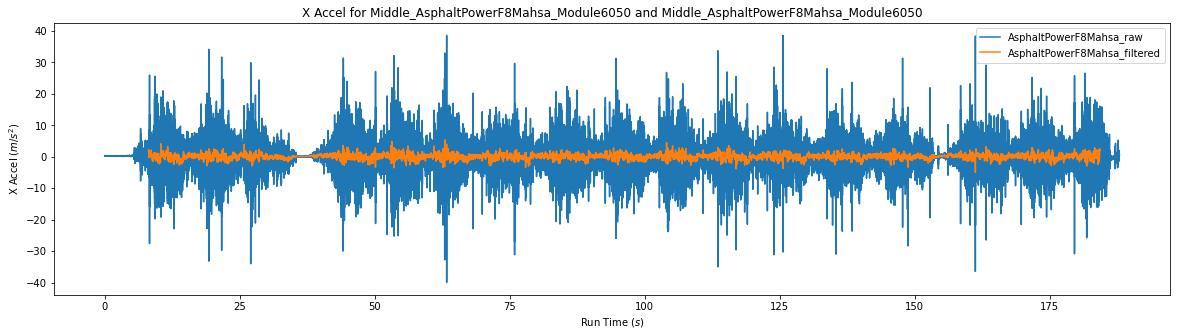

<Figure size 432x288 with 0 Axes>

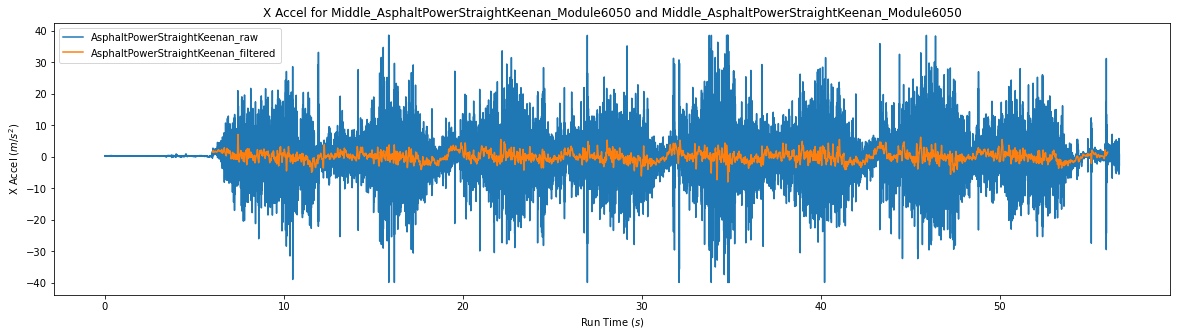

<Figure size 432x288 with 0 Axes>

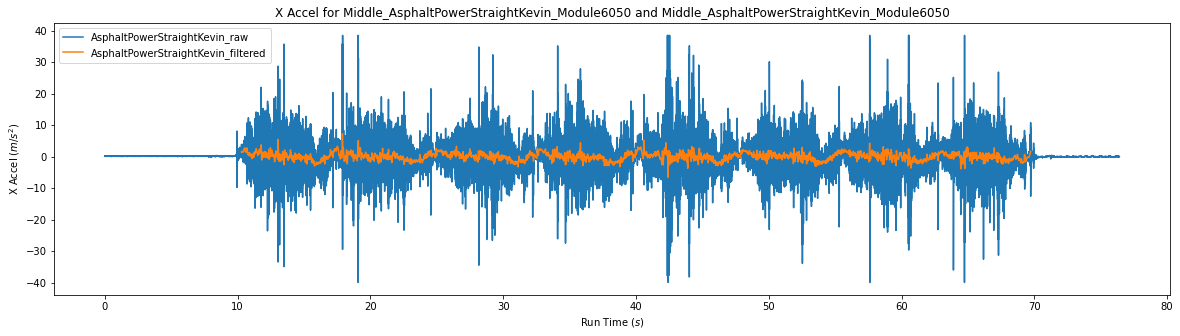

<Figure size 432x288 with 0 Axes>

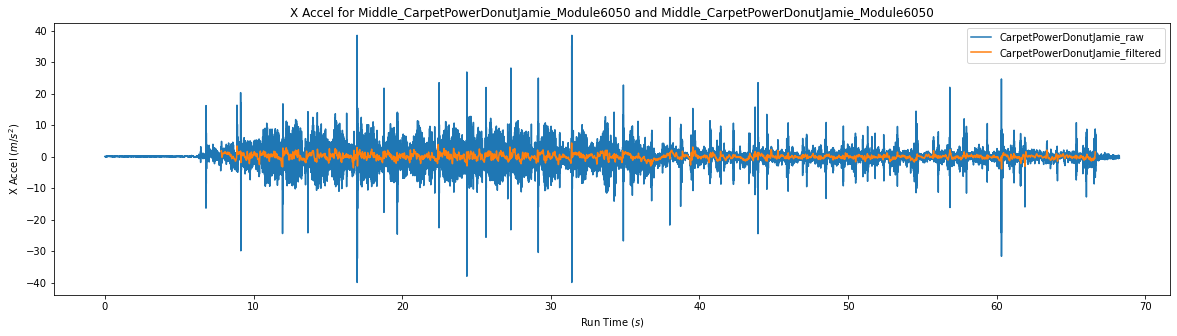

<Figure size 432x288 with 0 Axes>

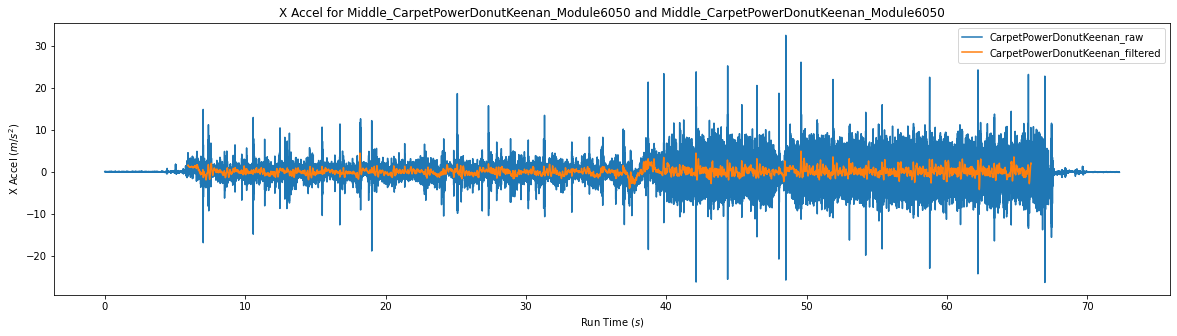

<Figure size 432x288 with 0 Axes>

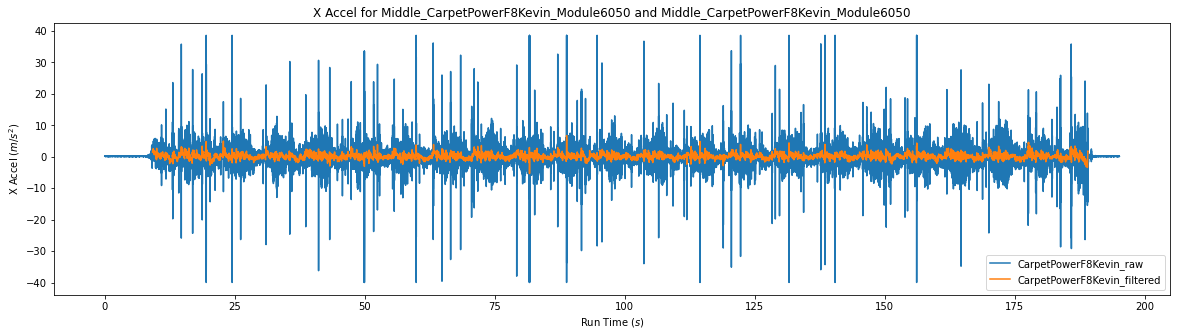

<Figure size 432x288 with 0 Axes>

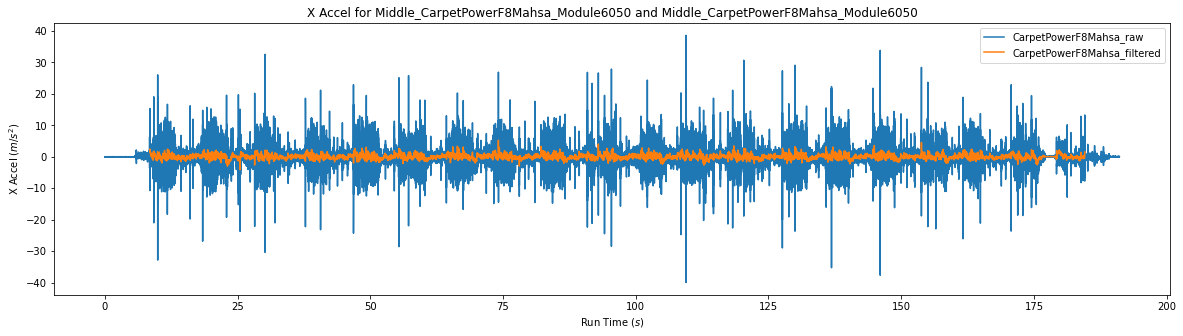

<Figure size 432x288 with 0 Axes>

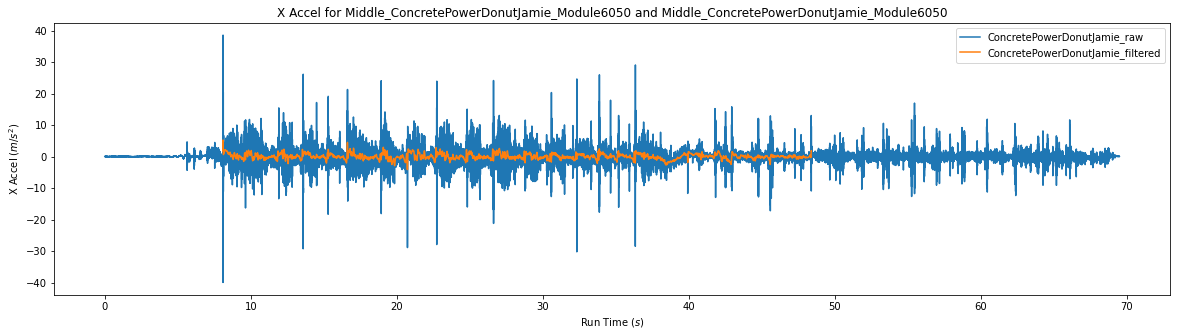

<Figure size 432x288 with 0 Axes>

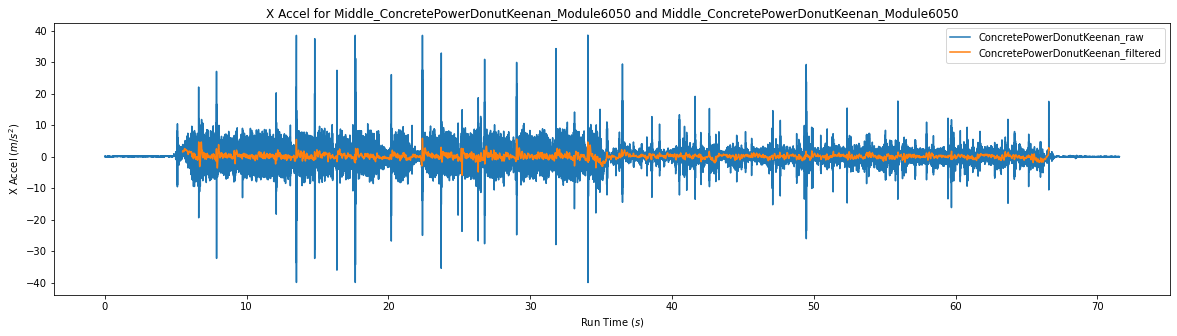

<Figure size 432x288 with 0 Axes>

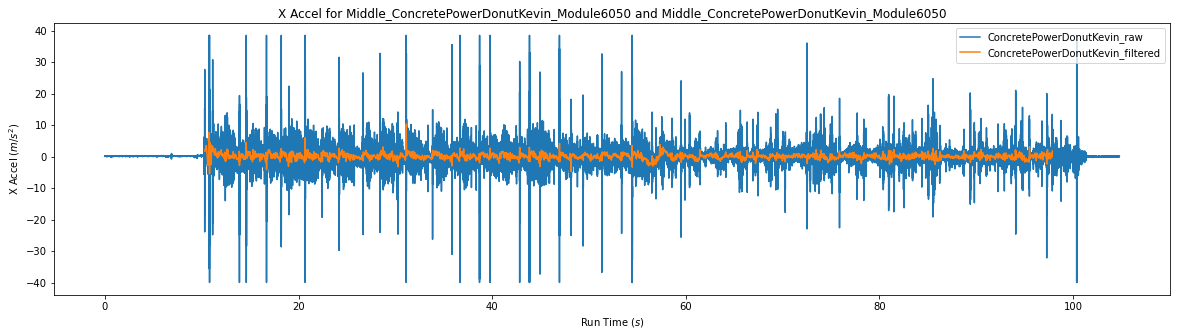

<Figure size 432x288 with 0 Axes>

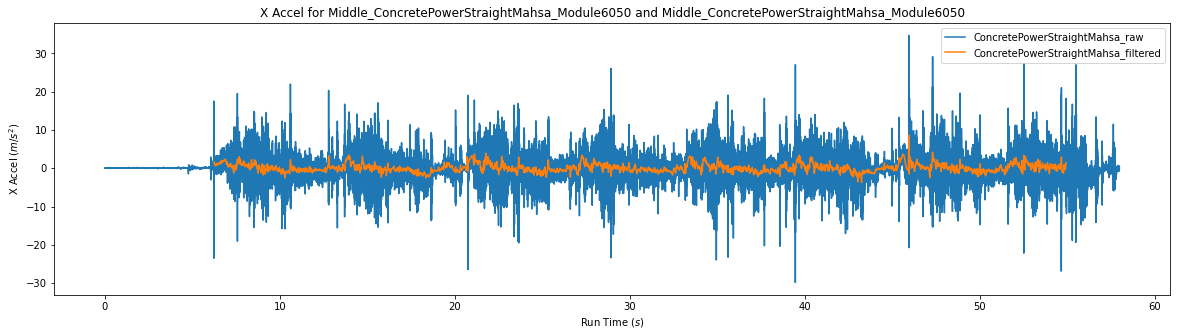

<Figure size 432x288 with 0 Axes>

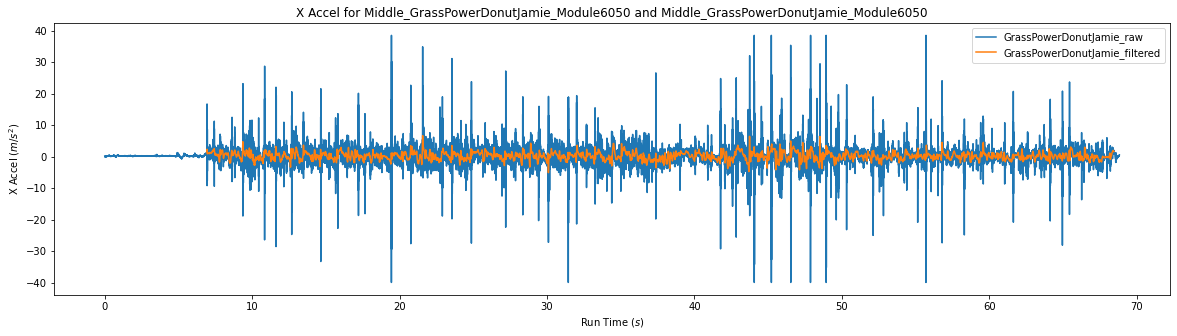

<Figure size 432x288 with 0 Axes>

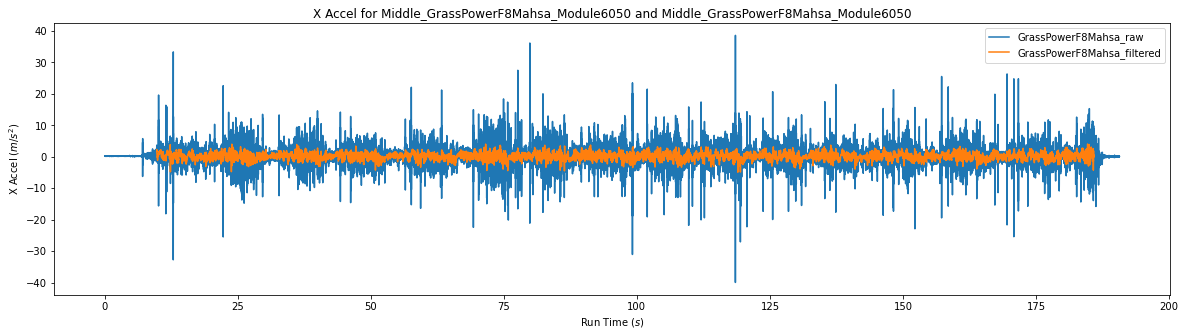

<Figure size 432x288 with 0 Axes>

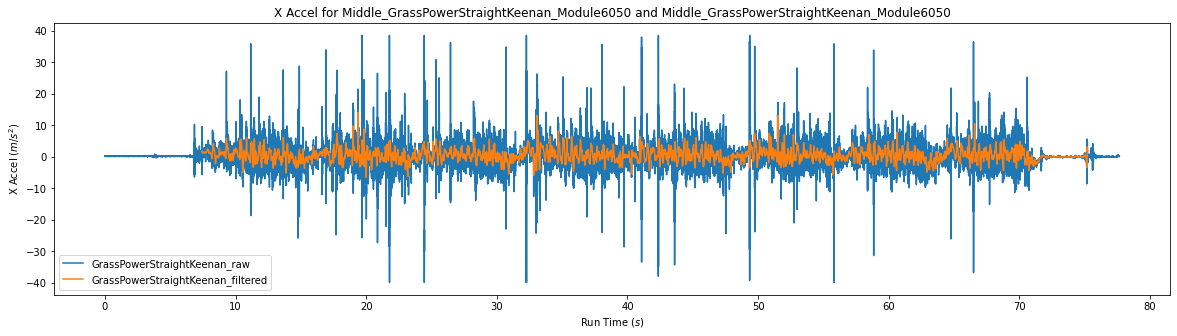

<Figure size 432x288 with 0 Axes>

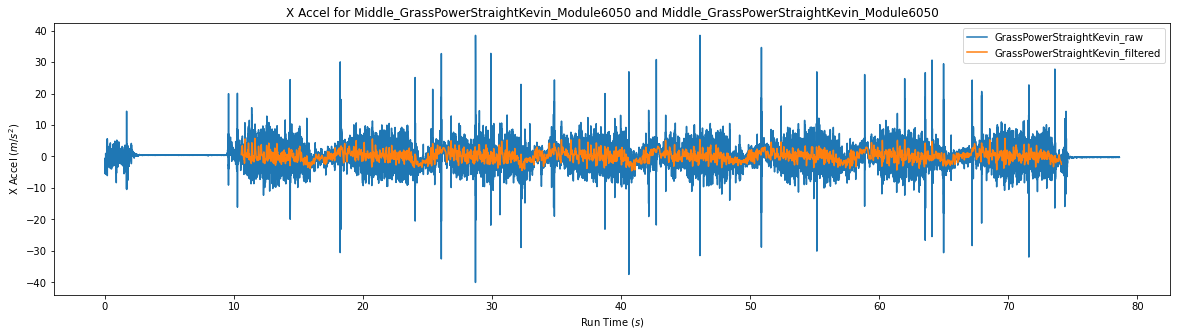

<Figure size 432x288 with 0 Axes>

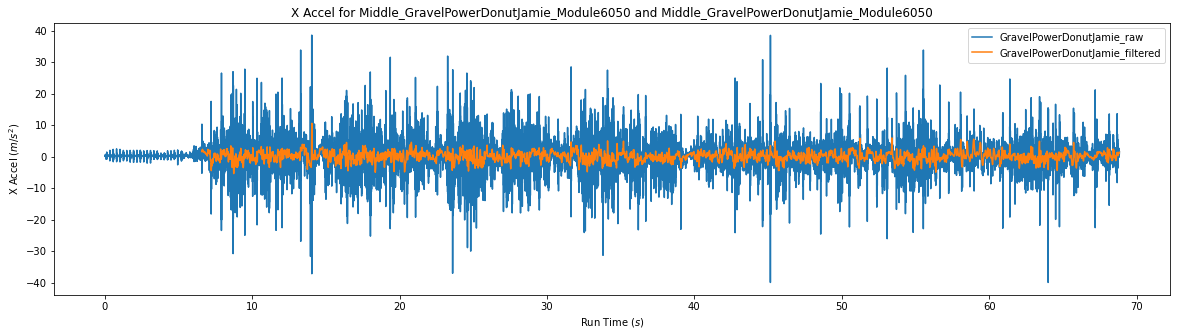

<Figure size 432x288 with 0 Axes>

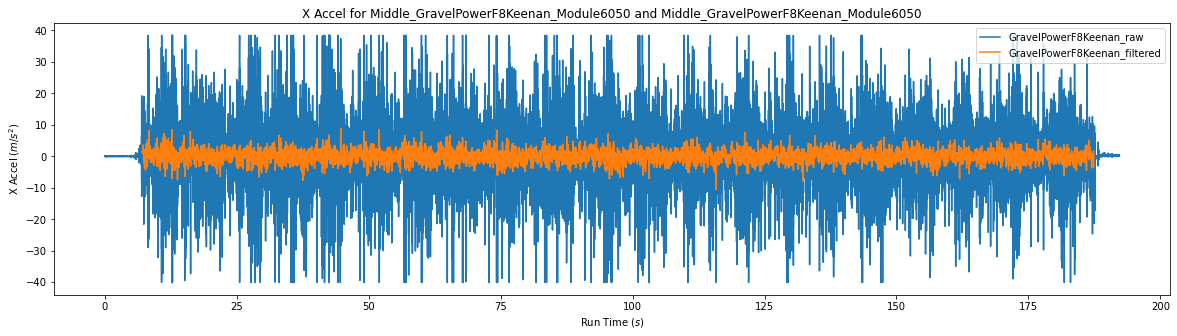

<Figure size 432x288 with 0 Axes>

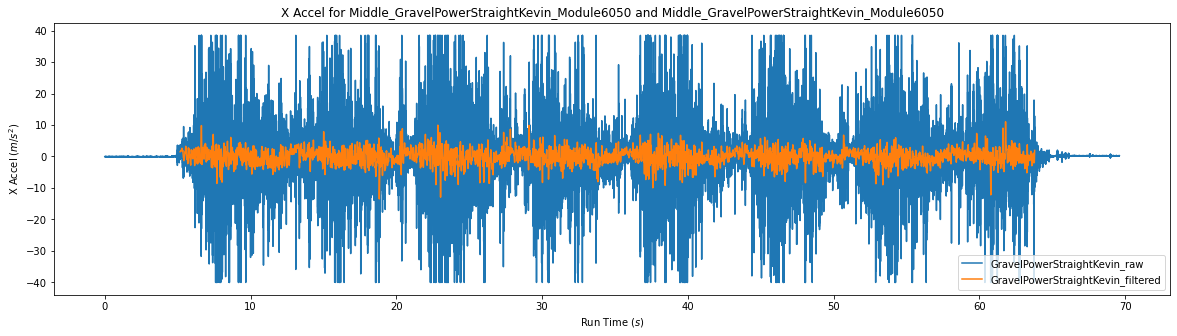

<Figure size 432x288 with 0 Axes>

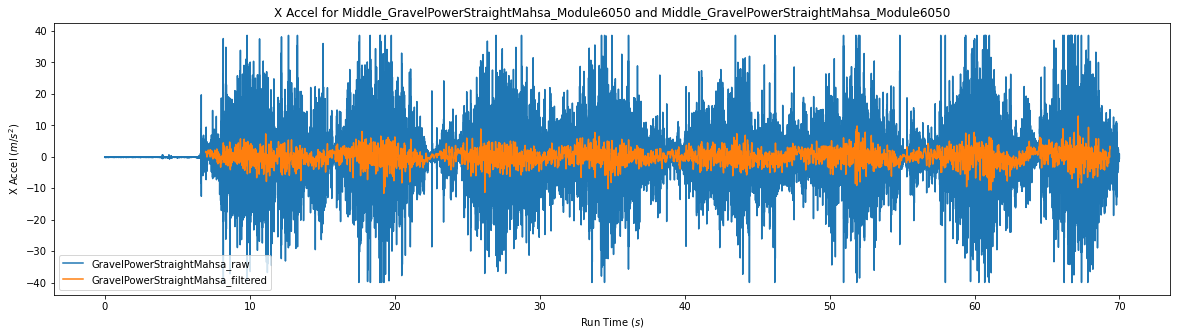

<Figure size 432x288 with 0 Axes>

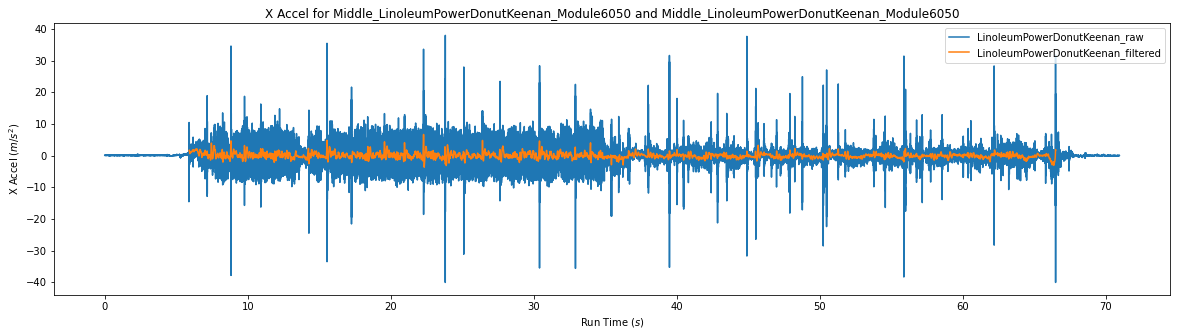

<Figure size 432x288 with 0 Axes>

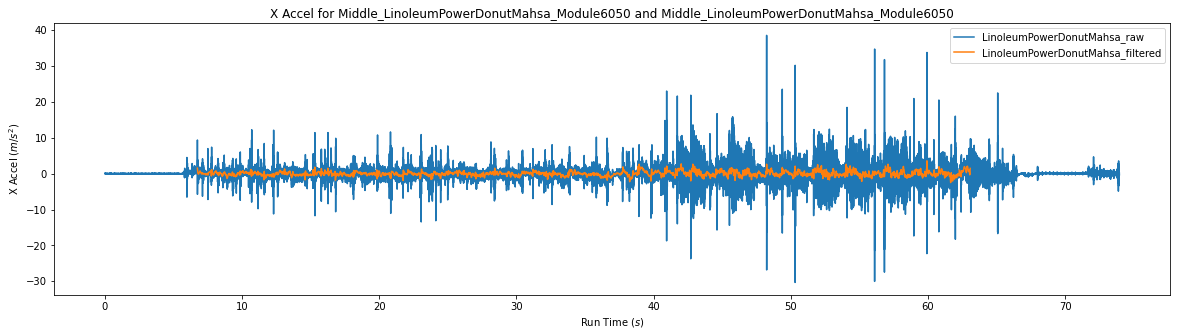

<Figure size 432x288 with 0 Axes>

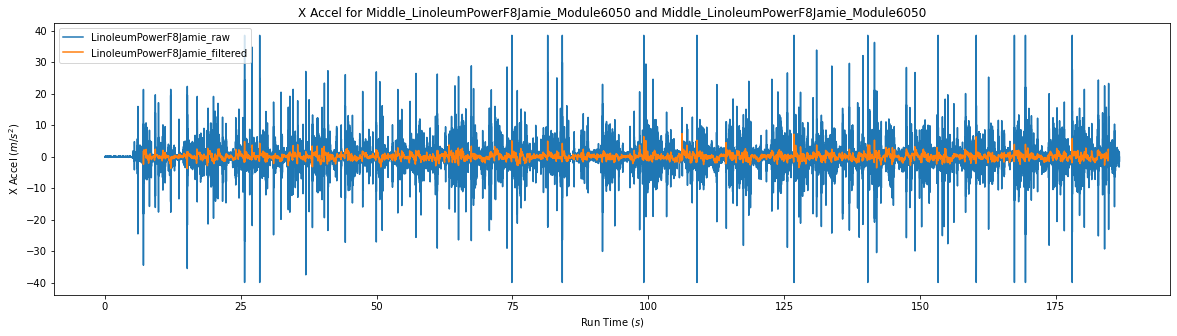

<Figure size 432x288 with 0 Axes>

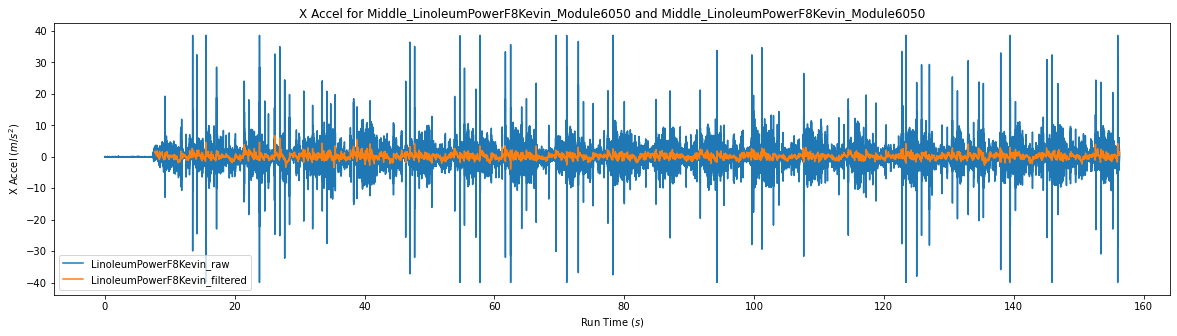

<Figure size 432x288 with 0 Axes>

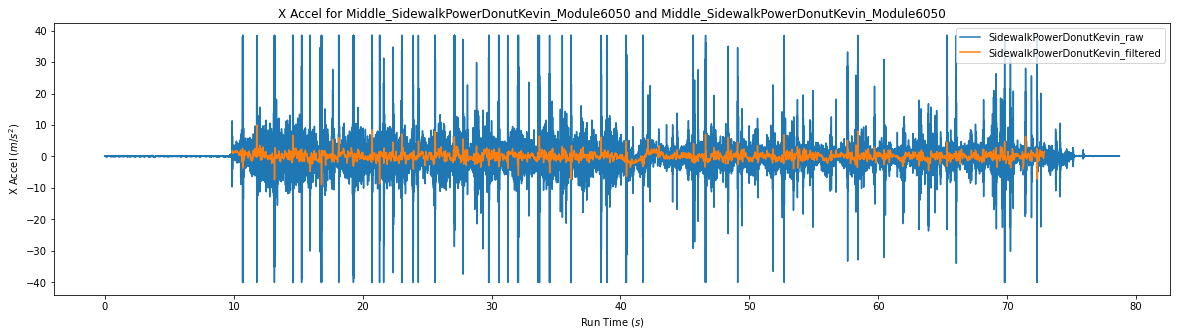

<Figure size 432x288 with 0 Axes>

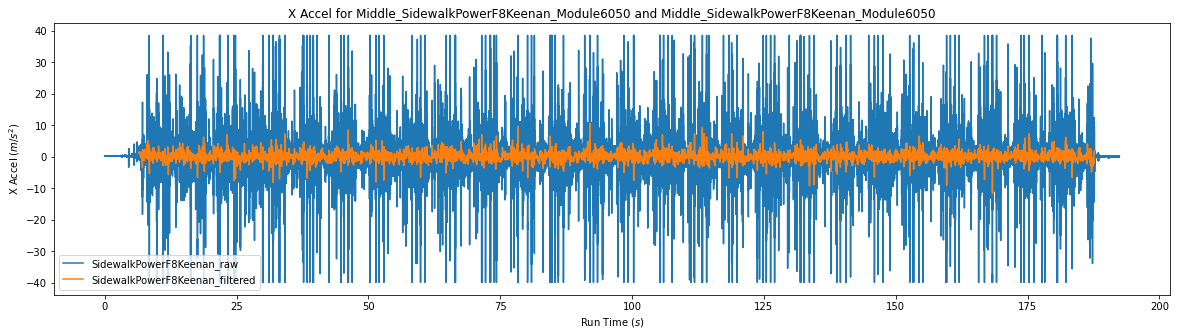

<Figure size 432x288 with 0 Axes>

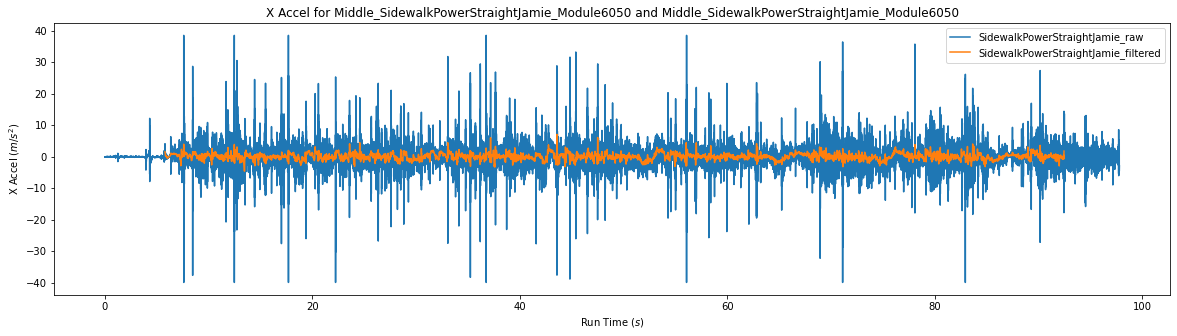

<Figure size 432x288 with 0 Axes>

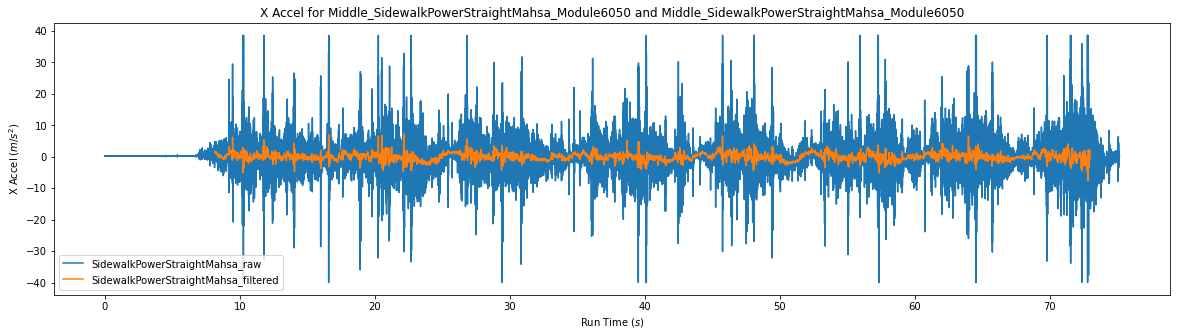

In [35]:
# compare filtered and unfiltered data
for i in range(len(dataset_labels)):
    dataset_compare(raw_datasets, dataset_labels[i], all_datasets, dataset_labels[i], 
                    'X Accel', Filtered = True)

In [36]:
# combine motion & no-motion datasets
all_datasets.update({'no_motion':noMotion_dataset})

for label, dataset in all_datasets.items():
    dataset = dataset.drop(['Run Time', 'Epoch Time'], axis='columns')
    all_datasets.update({label:dataset})

all_datasets[dataset_labels[0]].head()

X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro
2247  1.958967  0.960101 -1.207948 -0.051598 -0.037609  0.350399
2248  2.525045  1.116748 -1.474656 -0.056036 -0.053235  0.357455
2249  3.004019  1.224124 -1.640721 -0.053761 -0.066499  0.357655
2250  3.213754  1.238883 -1.636838 -0.043987 -0.072307  0.351325
2251  3.131048  1.161075 -1.461366 -0.027611 -0.068712  0.340227

## Part 5 - Data segmentation & Windowing (using hanning window)

In [37]:
def slice_window(datasets, overlap = True):

    '''
    WINDOWING 
    By using windowing functions, you can further enhance the ability of an FFT to extract spectral data from signals. 
    Windowing functions act on raw data to reduce the effects of the leakage that occurs during an FFT of the data. 
    Leakage amounts to spectral information from an FFT showing up at the wrong frequencies.

    '''
    segmented_datasets = {} # creating a dictionary of lists of sliced (N=512) dataframes 
    windowed_datasets = {} # creating a dictionary of sliced & windowed dataframes - this would be used for fft/psd only 

    # Trim excess data points, then split into short segments
    for label, dataset in datasets.items():
        
        # window size
        window_size = SAMP_SLICE 

        # create an empty list of Sliced/Windowed dataframes
        segmented_dataset = []
        windowed_dataset = []

        # Iterate through dataset by half a window at a time and extract segments
        i = 0

        # whether to have overalping or non-overlaping segments
        if overlap:
            window_slide = int(window_size / 2) # to create 50% overalping segments
        else:
            window_slide = window_size

        # create hanning window
        win = np.hanning(window_size)

        while (i + window_size  <= len(dataset)):

            # update the list of segmented dataframes
            segmented_dataset.append(dataset[i:i + window_size])

            # multiply han window & data segments
            dataset_copy = dataset[i:i + window_size] * win[:,None]

            # update the list of windowed segments
            windowed_dataset.append(dataset_copy)

            # slide forward
            i += window_slide

        segmented_datasets.update({label: segmented_dataset})
        windowed_datasets.update({label: windowed_dataset})
        
    return segmented_datasets, windowed_datasets

In [38]:
# create a dictionary of segmented & windowed dataframes
segmented_datasets, windowed_datasets = slice_window(all_datasets)

In [39]:
# Check if its constructed correctly
print('Total num segmented/windowed datasets: {}'.format(len(windowed_datasets)))
print('Num of segments (time windows) in first dataset: {}'.format(len(windowed_datasets[dataset_labels[0]])))
print('Shape of individual window in the first dataset: {}'.format(windowed_datasets[dataset_labels[0]][0].shape))
print('Shape of original dataframe in the first dataset: {}'.format(all_datasets[dataset_labels[0]].shape))
print('type of the first dataset:{}'.format(type(windowed_datasets[dataset_labels[0]])))
print('type of the first window in the first dataset:{}'.format(type(windowed_datasets[dataset_labels[0]][0])))

Total num segmented/windowed datasets: 29
Num of segments (time windows) in first dataset: 32
Shape of individual window in the first dataset: (1024, 6)
Shape of original dataframe in the first dataset: (17179, 6)
type of the first dataset:<class 'list'>
type of the first window in the first dataset:<class 'pandas.core.frame.DataFrame'>


In [40]:
print('Example of a segmented dataframe')
segmented_datasets[dataset_labels[0]][0]

Example of a segmented dataframe


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro
2247  1.958967  0.960101 -1.207948 -0.051598 -0.037609  0.350399
2248  2.525045  1.116748 -1.474656 -0.056036 -0.053235  0.357455
2249  3.004019  1.224124 -1.640721 -0.053761 -0.066499  0.357655
2250  3.213754  1.238883 -1.636838 -0.043987 -0.072307  0.351325
2251  3.131048  1.161075 -1.461366 -0.027611 -0.068712  0.340227
...        ...       ...       ...       ...       ...       ...
3266  0.807401  2.475766 -0.316218 -0.002114  0.035523  1.414029
3267  0.693140  2.490736 -0.313031  0.003157  0.023662  1.406828
3268  0.506835  2.491736 -0.328015  0.013027  0.010294  1.399136
3269  0.261259  2.462280 -0.359572  0.025376 -0.000844  1.390983
3270 -0.006100  2.389407 -0.392467  0.037200 -0.005780  1.382164

[1024 rows x 6 columns]

In [41]:
examine two consecutive segmented/windowed dataframe
j = 0
fig, ax = plt.subplots(2,1, figsize = (8, 6))

for i in range(60,62):
    ax[j].plot(segmented_datasets[dataset_labels[0]][i]['X Accel'], label='filtered')
    ax[j].plot(windowed_datasets[dataset_labels[0]][i]['X Accel'], label='windowed')
    ax[j].legend()
    ax[j].set_xlabel('index')
    ax[j].set_ylabel('segmented window #{}'.format(i))
    j+=1

## Part 6 - Transforms (FFT, PSD)

### 6.1. Function to perform Fast Fourier Transform 

In [42]:
def fft_transform(datasets):
    
    '''function to create a dictionary of all FFT'd dataframes'''
    
    fft_datasets = {}
    
    # number of sample points
    N = SAMP_SLICE

    # sample spacing
    T = 1/f_samp_6050
    
    # Frequency bin centers
    xf = fftfreq(N,T)[:N//2]

    # Find the FFT of each column of each data window of each dataset
    for label, dataset_list in datasets.items():

        fft_dataset = []

        for window in dataset_list:     

            # create an emtpy dataframe
            fft_df = pd.DataFrame(columns=data_columns)

            # calculate fft of each time window 
            for i, column in enumerate(data_columns):

                # calculate fft of each column
                y = fft(window[column].values)
                yf = 2.0/N * abs(y[0:N//2]) # keeping positive frequencies

                # add fft'd signal to a dataframe
                fft_df[column] = yf

            # Append the frequency column
            fft_df['frequency'] = xf

            fft_dataset.append(fft_df)

        fft_datasets.update({label: fft_dataset})   
            
    return(fft_datasets)

In [43]:
# create a dictionary containing lists of fft'd windowed segments
fft_datasets = fft_transform(windowed_datasets)

In [44]:
# Check if fft_datasets are constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(fft_datasets)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(fft_datasets[dataset_labels[0]])))
print('Shape of FFT\'d individual window: {}'.format(fft_datasets[dataset_labels[0]][0].shape))
fft_datasets[dataset_labels[0]][0].head()

Num of FFT'd windowed datasets: 29
Num of FFT'd windows in first dataset: 32
Shape of FFT'd individual window: (512, 7)


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  frequency
0  0.225882  0.923272  0.033714  0.021105  0.017422  0.603915   0.000000
1  0.045862  0.487633  0.002302  0.010735  0.014571  0.351738   0.292969
2  0.144650  0.226173  0.019158  0.009785  0.013678  0.202169   0.585938
3  0.078428  0.095452  0.020887  0.005618  0.007427  0.060796   0.878906
4  0.297911  0.082104  0.024152  0.005994  0.005020  0.035870   1.171875

### 6.2. Creating PSD datasets

In [45]:
def psd_transform(datasets):
    
    '''function to create a dictionary of all PSD'd dataframes'''

    psd_datasets = {}
    
    # number of sample points
    N = SAMP_SLICE

    # sampling frequency
    fs = f_samp_6050

    # Find the PSD of each column of each data window of each dataset
    for label, dataset_list in datasets.items():

        psd_dataset = []

        for window in dataset_list:     

            # create an emtpy dataframe
            psd_df = pd.DataFrame(columns=data_columns)

            # calculate psd of each time window 
            for i, column in enumerate(data_columns):

                # calculate psd of each column
                f, Pxx_den = welch(window[column].values, fs)

                # add psd'd signal to a dataframe
                psd_df[column] = Pxx_den

            # Append the frequency column
            psd_df['frequency'] = f

            psd_dataset.append(psd_df)

        psd_datasets.update({label: psd_dataset})   
            
    return(psd_datasets)

In [46]:
# create a dictionary containing lists of psd'd windowed segments
psd_datasets = psd_transform(segmented_datasets)

In [47]:
# Check if fft_datasets are constructed correctly
print('Num of PSD\'d windowed datasets: {}'.format(len(psd_datasets)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(psd_datasets[dataset_labels[0]])))
print('Shape of PSD\'d individual window: {}'.format(psd_datasets[dataset_labels[0]][0].shape))
psd_datasets[dataset_labels[0]][0].head()

Num of PSD'd windowed datasets: 29
Num of PSD'd windows in first dataset: 32
Shape of PSD'd individual window: (129, 7)


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  frequency
0  0.023366  0.003178  0.000104  0.000020  0.000048  0.001797   0.000000
1  0.125093  0.045412  0.000744  0.000102  0.000238  0.021950   1.171875
2  0.114395  0.021142  0.003092  0.000124  0.000181  0.005951   2.343750
3  0.064612  0.005460  0.004381  0.000052  0.000124  0.000874   3.515625
4  0.035050  0.004859  0.006288  0.000026  0.000094  0.000374   4.687500

### 6.3. Plot function for frequency domain dataset

In [48]:
def plot_transforms(fft, psd):
    
    '''function to visualise a random window of a random dataset from fft/psd transforms'''
    
    # choose a random dataframe
    i = randrange(len(fft)-1)
    j = randrange(len(fft[dataset_labels[i]])-1)
    
    print(dataset_labels[i],'\nwindow #{}'.format(j))
    df_fft = fft[dataset_labels[i]][j]
    df_psd = psd[dataset_labels[i]][j]
    
    fig, ax = plt.subplots(1,2, figsize = (12,4))    
    
    for col in data_columns:
        ax[0].plot(df_fft['frequency'], df_fft[col], label=col)
        ax[1].plot(df_psd['frequency'], df_psd[col], label=col)
        
    ax[0].set_xlabel('frequency (hz)'); ax[1].set_xlabel('frequency (hz)') 
    ax[0].set_ylabel('fft'); ax[1].set_ylabel('psd') 
    ax[0].legend(); ax[1].legend()
    plt.show()

Middle_ConcretePowerDonutKevin_Module6050 
window #30


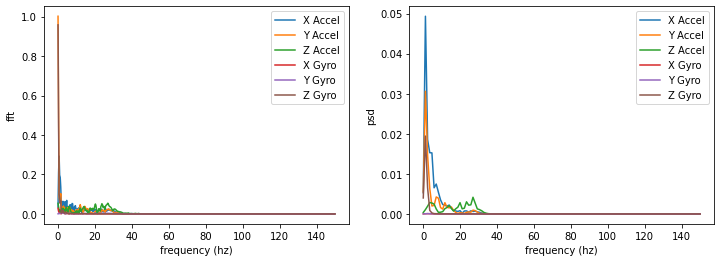

In [49]:
plot_transforms(fft_datasets, psd_datasets)

### 6.4. Trim excessive unused frequencies

In [50]:
def trim_transforms(datasets, freq_thresh):
    
    ''' function to remove excessive frequency bins of fft & psd dataframes'''

    datasets_trimmed = {}
    
    for label, dataset_list in datasets.items():
        dataset_trimmed_list =[]
        
        for dataset in dataset_list:
            # remove frequencies higher than freq_thresh
            dataset_trimmed_list.append(dataset[dataset['frequency'] <= freq_thresh].copy())
            
        datasets_trimmed.update({label: dataset_trimmed_list})
    return datasets_trimmed

In [51]:
# trim fft & psd dataframes to keep useful frequencies only
fft_datasets_trimmed= trim_transforms(fft_datasets, CUT_OFF + 10)
psd_datasets_trimmed= trim_transforms(psd_datasets, CUT_OFF + 10)

In [52]:
# Check if fft_datasets are constructed correctly
print('Num of PSD\'d windowed datasets: {}'.format(len(fft_datasets_trimmed)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(fft_datasets_trimmed[dataset_labels[0]])))
print('Shape of PSD\'d individual window: {}'.format(fft_datasets_trimmed[dataset_labels[0]][0].shape))
fft_datasets_trimmed[dataset_labels[0]][0].head()

Num of PSD'd windowed datasets: 29
Num of PSD'd windows in first dataset: 32
Shape of PSD'd individual window: (103, 7)


X Accel   Y Accel   Z Accel    X Gyro    Y Gyro    Z Gyro  frequency
0  0.225882  0.923272  0.033714  0.021105  0.017422  0.603915   0.000000
1  0.045862  0.487633  0.002302  0.010735  0.014571  0.351738   0.292969
2  0.144650  0.226173  0.019158  0.009785  0.013678  0.202169   0.585938
3  0.078428  0.095452  0.020887  0.005618  0.007427  0.060796   0.878906
4  0.297911  0.082104  0.024152  0.005994  0.005020  0.035870   1.171875

full frequency range fft/psd datasets
Middle_GravelPowerF8Keenan_Module6050 
window #12


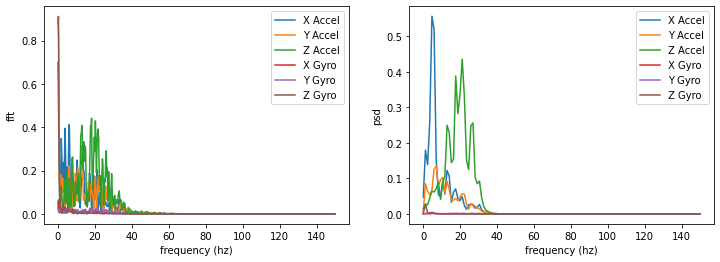

fft/psd trimeed datasets
Middle_ConcretePowerStraightMahsa_Module6050 
window #13


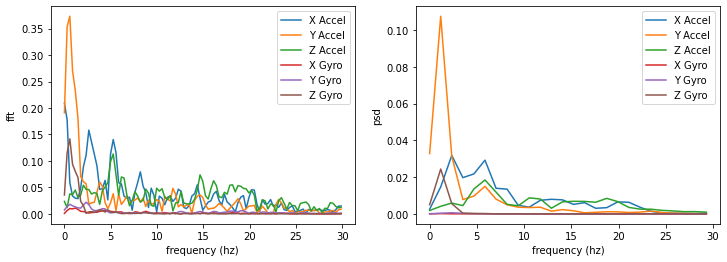

In [53]:
# compare trimmed & original fft datasets
print('full frequency range fft/psd datasets')
plot_transforms(fft_datasets, psd_datasets)
print('fft/psd trimeed datasets')
plot_transforms(fft_datasets_trimmed, psd_datasets_trimmed)

## Part 7 - Feature Engineering
#### Extract relevant features (e.g. Mean, Min, Skew, ...) from each data window

### 7.1. Feature Extraction Functions (l2norm, autocorr, rms, zcr, msf, rmsf, fc, vf, rvf)

In [54]:
# Feature extraction functions
def l2norm(array):
    '''L2 norm of an array'''
    return np.linalg.norm(array, ord=2)

def rms(array):
    '''Root mean squared of an array'''
    return np.sqrt(np.mean(array ** 2))

def zcr(array):
    '''Zero crossing rate of an array as a fraction of total size of array'''
    # divide by total datapoints in window
    return len(np.nonzero(np.diff(np.sign(array)))[0]) / len(array)

In [55]:

def feature_extraction(datasets, features_dic, freq_domain = False):
    
    '''Extract given features from column of each dataset
       Converts a dictionary of datasets to a nested dictionary where each dataset has its own dictionary
       of axes/directions'''
    
    # will be updated with a nested dictionary of {label:{data column name:[dataframe with feature extracted columns]}}
    feat_datasets = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset_list in datasets.items():
        
        # will be updated with keys as data columns (e.g., 'X Accel') 
        cols_dic = {}
        
        # Loop over data columns
        for col in data_columns:
            
            # will be updated with keys as extracted feature names (e.g., 'Mean')
            feats = {}
            
            if not freq_domain:
            
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    featured_column = []

                    for window in dataset_list:

                        # update a list of extracted feature for the ith column 
                        featured_column.append(function(window[col]))

                    return featured_column 
                
            else:
                
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    featured_column = []
                    
                    for window in dataset_list:
                        featured_column.append(function(window.iloc[:, -1], window[col]))
                    
                    return featured_column
            
            # Execute every function over all windows    
            for feat_name, feat_func in features_dic.items():

                # apply feature extraction to the ith column for all windows
                feats.update({feat_name: function_all_windows(feat_func)})

            cols_dic.update({col: pd.DataFrame.from_dict(feats)})
        
        feat_datasets.update({label: cols_dic})

    return feat_datasets

### 7.2. Time Domain Features

In [56]:
# dictionary of time-domain features to use in feature extraction step
time_features = {'Mean': np.mean, 'Std': np.std,  'Norm': l2norm, 
                 'Max': np.amax, 'Min' : np.amin, 'RMS': rms, 'ZCR': zcr} 

In [57]:
# create a dictionary of feature extracted dataframes
time_featured_datasets = feature_extraction(segmented_datasets, time_features)

In [58]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(time_featured_datasets)))
print('Num windows: {}'.format(len(time_featured_datasets[dataset_labels[1]])))
print('Shape of first dataset first column: {}'.format(time_featured_datasets[dataset_labels[1]]['X Accel'].shape))
time_featured_datasets[dataset_labels[1]]['X Accel'].head()

Num datasets: 29
Num windows: 6
Shape of first dataset first column: (102, 7)


Mean       Std       Norm       Max       Min       RMS       ZCR
0  0.322706  0.896415  30.487433  4.127456 -2.264548  0.952732  0.050781
1  0.173034  0.988859  32.124293  4.127456 -2.446605  1.003884  0.053711
2 -0.233638  0.960789  31.641228  3.249568 -2.599914  0.988788  0.045898
3 -0.111570  0.796149  25.725718  1.597984 -2.599914  0.803929  0.033203
4  0.241993  0.492378  17.556219  2.201478 -1.705602  0.548632  0.048828

In [59]:
def plot_set_features(datasets, dirn, feat_name):
    
    '''Plot extracted feature of one direction for all terrains'''
    
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets.items():
        plt.plot(dataset[dirn][feat_name], label=label)
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(dirn)
    plt.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

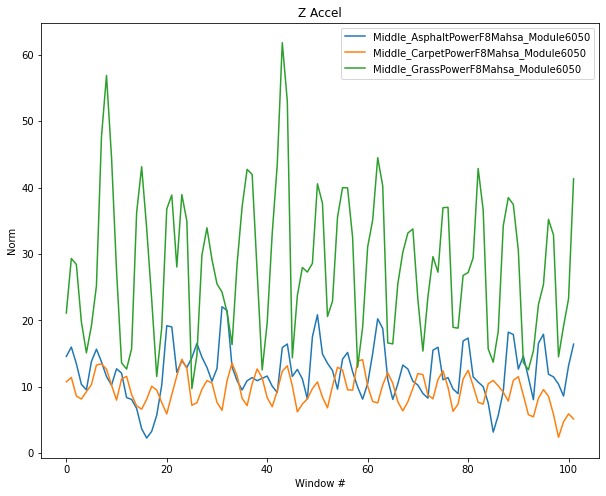

In [60]:
# Plot some time feature data
feat_datasets_to_plot = {label: dataset for label, dataset in time_featured_datasets.items()
                         if 'Middle' in label and 'Mahsa' in label and 'F8' in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='Norm')

### 7.3. Frequency Domain Features

In [61]:
# For small float values
EPSILON = 0.00001

def msf(freqs, psd_amps):
    '''Mean square frequency'''
    num = np.sum(np.multiply(np.resize(np.power(freqs,2), len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

def rmsf(freqs, psd_amps):
    '''Root mean square frequency'''
    return np.sqrt(msf(freqs, psd_amps))

def fc(freqs, psd_amps):
    '''Frequency center'''
    num = np.sum(np.multiply(np.resize(freqs, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

def vf(freqs, psd_amps):
    '''Variance frequency'''
    return msf(freqs-fc(freqs, psd_amps), psd_amps)

def rvf(freqs, psd_amps):
    '''Root variance frequency'''
    return np.sqrt(msf(freqs, psd_amps))

In [62]:
# dictionary of freq-domain features to use in feature extraction step
freq_features = {'RMSF': rmsf, 'FC': fc, 'RVF': rvf}

In [63]:
# create a dictionary of freq-domain feature extracted dataframes
freq_featured_datasets = feature_extraction(psd_datasets_trimmed, freq_features, freq_domain = True)

In [64]:
# Check if feature data is constructed correctly and print some info
print('Num datasets: {}'.format(len(freq_featured_datasets)))
print('Num directions: {}'.format(len(freq_featured_datasets[dataset_labels[0]])))
print('Shape of one direction: {}'.format(freq_featured_datasets[dataset_labels[0]]['X Accel'].shape))
freq_featured_datasets[dataset_labels[0]]['X Accel'].head()

Num datasets: 29
Num directions: 6
Shape of one direction: (32, 3)


RMSF        FC        RVF
0   8.048273  6.149016   8.048273
1   7.984941  5.885248   7.984941
2   9.800583  6.943039   9.800583
3  10.715512  8.262469  10.715512
4   9.982904  7.704395   9.982904

<Figure size 432x288 with 0 Axes>

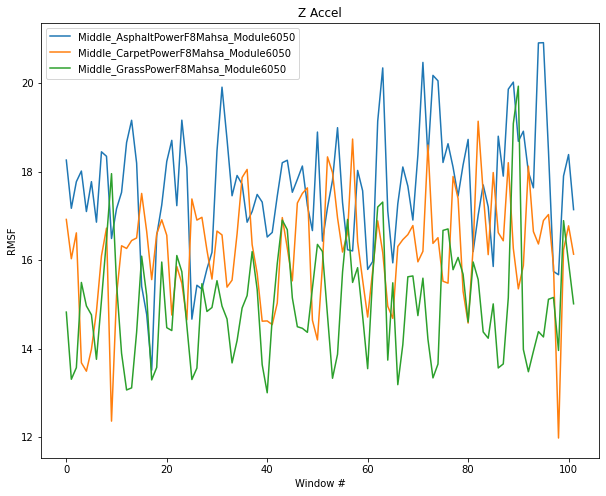

In [65]:
# Plot some frequency feature data
feat_datasets_to_plot = {label: feature for label, feature in freq_featured_datasets.items()
                         if 'Mahsa' in label and 'F8' in label}
plot_set_features(feat_datasets_to_plot, dirn='Z Accel', feat_name='RMSF')

## Part 8 - Columning, Combination, and Standardization of Datasets

### 8.1. Columning Data
##### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

In [66]:
def append_all_columns(columns, append_tag):

    '''Append a tag to the end of every column name of a dataframe'''

    new_columns = []
    
    for column in columns:
        if append_tag not in column:
            new_columns.append(column + ' ' + append_tag)
        else:
            new_columns.append(column)
    
    return new_columns

#### 8.1.1. Time & Freq Extracted Featured Data

In [67]:
def combine_extracted_columns(datasets):
    
    '''Combined directions (axes) of a featured dataset'''

    combined_datasets = {}
    
    for label, dataset_dic in datasets.items():
        
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for col_label, df in dataset_dic.items():
            df_copy = pd.DataFrame(df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(df.columns, col_label)
            
            df_combined = df_combined.join(df, how='outer')
        
        combined_datasets.update({label: df_combined})
    
    return combined_datasets

In [68]:
# Take time feature data and combine axes columns
columned_time_feat_datasets = combine_extracted_columns(time_featured_datasets)

# Confirm formatting
columned_time_feat_datasets[dataset_labels[0]].head()

Mean X Accel  Std X Accel  Norm X Accel  Max X Accel  Min X Accel  \
0      0.490972     0.950083     34.222229     5.280722    -2.013216   
1      0.429220     0.998314     34.773568     5.280722    -2.030122   
2      0.028369     0.962901     30.826215     2.670142    -2.675289   
3     -0.166364     0.929699     30.222942     2.438926    -2.675289   
4      0.017092     0.930912     29.794211     2.541473    -2.524794   

   RMS X Accel  ZCR X Accel  Mean Y Accel  Std Y Accel  Norm Y Accel  ...  \
0     1.069445     0.024414      1.024263     0.626396     38.419824  ...   
1     1.086674     0.031250      1.086302     0.653990     40.575133  ...   
2     0.963319     0.052734      1.196277     0.544166     42.055290  ...   
3     0.944467     0.068359      1.565490     0.603847     53.693199  ...   
4     0.931069     0.064453      1.688857     0.553667     56.873497  ...   

   Min Y Gyro  RMS Y Gyro  ZCR Y Gyro  Mean Z Gyro  Std Z Gyro  Norm Z Gyro  \
0   -0.215704    0.052778    0.087891     0.698806    0.401475    25.789537   
1   -0.215704    0.050761    0.093750     0.742145    0.436537    27.552428   
2   -0.269596    0.074675    0.091797     0.941653    0.296544    31.591772   
3   -0.269596    0.084458    0.082031     1.041890    0.272848    34.464776   
4   -0.184262    0.068389    0.071289     1.027757    0.252753    33.868174   

   Max Z Gyro  Min Z Gyro  RMS Z Gyro  ZCR Z Gyro  
0    1.489304   -0.278037    0.805923    0.001953  
1    1.626520   -0.278037    0.861013    0.001953  
2    1.626520    0.302023    0.987243    0.000000  
3    1.624010    0.526471    1.077024    0.000000  
4    1.497907    0.585388    1.058380    0.000000  

[5 rows x 42 columns]

In [69]:
# Take frequency feature data and axes columns
columned_freq_feat_datasets = combine_extracted_columns(freq_featured_datasets)

# Confirm formatting
columned_freq_feat_datasets[dataset_labels[0]].head()

RMSF X Accel  FC X Accel  RVF X Accel  RMSF Y Accel  FC Y Accel  \
0      8.048273    6.149016     8.048273      9.444501    6.638204   
1      7.984941    5.885248     7.984941      8.982319    6.065355   
2      9.800583    6.943039     9.800583     10.432468    7.134250   
3     10.715512    8.262469    10.715512     10.960555    7.634193   
4      9.982904    7.704395     9.982904      9.835037    6.667630   

   RVF Y Accel  RMSF Z Accel  FC Z Accel  RVF Z Accel  RMSF X Gyro  FC X Gyro  \
0     9.444501     17.714204   16.280908    17.714204     9.680661   7.287022   
1     8.982319     16.100315   14.006347    16.100315    11.055525   8.392184   
2    10.432468     17.689127   15.952424    17.689127    12.013069   9.381817   
3    10.960555     18.318273   16.903061    18.318273    11.283124   8.721337   
4     9.835037     17.748408   15.966089    17.748408     9.545448   6.990053   

   RVF X Gyro  RMSF Y Gyro  FC Y Gyro  RVF Y Gyro  RMSF Z Gyro  FC Z Gyro  \
0    9.680661    15.319790  12.427664   15.319790     1.887356   1.526287   
1   11.055525    14.845270  11.642735   14.845270     1.801210   1.451662   
2   12.013069    15.780374  12.942894   15.780374     1.802646   1.332285   
3   11.283124    16.191953  13.551576   16.191953     1.807651   1.272617   
4    9.545448    15.217434  11.926853   15.217434     1.756785   1.273357   

   RVF Z Gyro  
0    1.887356  
1    1.801210  
2    1.802646  
3    1.807651  
4    1.756785

#### 8.1.2. Transformed Data

In [70]:
def get_transform(_label):

    '''Get the transform used for given label'''

    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

In [71]:
def combine_transform_columns(datasets, trans = ''):
    
    '''Combined direction (axes) columns for transformed data'''

    combined_datasets = {}
    
    for label, dataset in datasets.items():
        
        # Get frequency bins from frequency column of first window
        freq_bins = dataset[0]['frequency'].tolist()
        
        # Get more parameter for current label
        trans = trans
        
        # Combine parameters to form columns for new combined DataFrame
        new_cols = [trans + ' {} Hz '.format(round(f_bin, 1)) + d_col for d_col in data_columns for f_bin in freq_bins]
        
        # Convert windowed arrays into a single array with each window as a row
        new_data = []
        
        for window in dataset:
            new_row = []
            for d_col in data_columns:
                new_row.extend(window[d_col].tolist())
            new_data.append(new_row)
            
        # Create new DataFrame
        combined_df = pd.DataFrame(data=new_data, columns=new_cols)
        combined_datasets.update({label: combined_df})

    return combined_datasets

In [72]:
columned_fft_datasets = combine_transform_columns(fft_datasets_trimmed, 'FFT')

# Confirm FFT formatting
columned_fft_datasets[dataset_labels[0]].head()

FFT 0.0 Hz X Accel  FFT 0.3 Hz X Accel  FFT 0.6 Hz X Accel  \
0            0.225882            0.045862            0.144650   
1            0.359624            0.319030            0.222317   
2            0.157327            0.324981            0.380763   
3            0.116145            0.116878            0.151122   
4            0.046108            0.214752            0.213847   

   FFT 0.9 Hz X Accel  FFT 1.2 Hz X Accel  FFT 1.5 Hz X Accel  \
0            0.078428            0.297911            0.310892   
1            0.170170            0.207375            0.227222   
2            0.302269            0.175073            0.035270   
3            0.023017            0.196451            0.302468   
4            0.182289            0.265545            0.212293   

   FFT 1.8 Hz X Accel  FFT 2.1 Hz X Accel  FFT 2.3 Hz X Accel  \
0            0.112676            0.031822            0.112407   
1            0.195202            0.097211            0.134099   
2            0.098494            0.141095            0.035150   
3            0.304405            0.121438            0.092450   
4            0.130828            0.064103            0.119556   

   FFT 2.6 Hz X Accel  ...  FFT 27.2 Hz Z Gyro  FFT 27.5 Hz Z Gyro  \
0            0.250784  ...            0.000171            0.000156   
1            0.187375  ...            0.000455            0.000288   
2            0.168449  ...            0.000469            0.000326   
3            0.199750  ...            0.000257            0.000202   
4            0.079394  ...            0.000572            0.000480   

   FFT 27.8 Hz Z Gyro  FFT 28.1 Hz Z Gyro  FFT 28.4 Hz Z Gyro  \
0            0.000130            0.000093            0.000152   
1            0.000512            0.000369            0.000205   
2            0.000418            0.000331            0.000177   
3            0.000278            0.000359            0.000166   
4            0.000480            0.000328            0.000378   

   FFT 28.7 Hz Z Gyro  FFT 29.0 Hz Z Gyro  FFT 29.3 Hz Z Gyro  \
0            0.000092            0.000167            0.000036   
1            0.000448            0.000300            0.000053   
2            0.000350            0.000452            0.000350   
3            0.000050            0.000336            0.000457   
4            0.000251            0.000027            0.000068   

   FFT 29.6 Hz Z Gyro  FFT 29.9 Hz Z Gyro  
0            0.000199            0.000063  
1            0.000223            0.000305  
2            0.000206            0.000225  
3            0.000271            0.000101  
4            0.000214            0.000230  

[5 rows x 618 columns]

In [73]:
columned_psd_datasets = combine_transform_columns(psd_datasets_trimmed, 'PSD')

# Check PSD formatting
columned_psd_datasets[dataset_labels[0]].head()

PSD 0.0 Hz X Accel  PSD 1.2 Hz X Accel  PSD 2.3 Hz X Accel  \
0            0.023366            0.125093            0.114395   
1            0.040089            0.154705            0.123809   
2            0.040656            0.146839            0.094277   
3            0.021780            0.118990            0.123354   
4            0.019752            0.126502            0.068140   

   PSD 3.5 Hz X Accel  PSD 4.7 Hz X Accel  PSD 5.9 Hz X Accel  \
0            0.064612            0.035050            0.050975   
1            0.069073            0.041267            0.070588   
2            0.049635            0.039603            0.031040   
3            0.038605            0.014371            0.038852   
4            0.023230            0.026448            0.044795   

   PSD 7.0 Hz X Accel  PSD 8.2 Hz X Accel  PSD 9.4 Hz X Accel  \
0            0.051418            0.038643            0.038751   
1            0.048452            0.032340            0.035982   
2            0.032145            0.019983            0.015178   
3            0.057776            0.029944            0.023659   
4            0.052871            0.040097            0.031443   

   PSD 10.5 Hz X Accel  ...  PSD 18.8 Hz Z Gyro  PSD 19.9 Hz Z Gyro  \
0             0.029871  ...            0.000002            0.000002   
1             0.025330  ...            0.000005            0.000004   
2             0.013988  ...            0.000004            0.000003   
3             0.034617  ...            0.000007            0.000003   
4             0.045621  ...            0.000005            0.000002   

   PSD 21.1 Hz Z Gyro  PSD 22.3 Hz Z Gyro  PSD 23.4 Hz Z Gyro  \
0        8.631001e-07            0.000001            0.000001   
1        3.228216e-06            0.000003            0.000004   
2        4.586708e-06            0.000003            0.000005   
3        3.534858e-06            0.000002            0.000002   
4        2.897791e-06            0.000001            0.000003   

   PSD 24.6 Hz Z Gyro  PSD 25.8 Hz Z Gyro  PSD 27.0 Hz Z Gyro  \
0        7.260774e-07        2.250156e-07        1.481640e-07   
1        1.701852e-06        5.882337e-07        1.035380e-06   
2        3.247747e-06        1.191483e-06        9.241570e-07   
3        3.080942e-06        2.636090e-06        9.062099e-07   
4        2.686437e-06        1.481459e-06        1.218781e-06   

   PSD 28.1 Hz Z Gyro  PSD 29.3 Hz Z Gyro  
0        1.016640e-07        1.365522e-07  
1        6.204871e-07        3.754892e-07  
2        4.506427e-07        2.933520e-07  
3        4.129411e-07        2.753945e-07  
4        6.082144e-07        2.125550e-07  

[5 rows x 156 columns]

### 8.2. Adding Labels

##### Create a new column containg the an integer label for each terrain.

In [74]:
def get_terrain_num(_label):

    '''Get the integer terrain value of a given label'''

    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return (i+1)
        elif 'no_motion' in _label:
            return 0
        
    raise Exception('Unknown terrain')

In [75]:
def insert_labels(datasets):
    
    'Add labels to a dataset'

    # Returns new datasets
    labeled_datasets = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        
        dataset_copy = dataset.copy()
        # get terrain label
        terrain_num = get_terrain_num(label)
        
        # create a list of labels for each dataset
        labels = [terrain_num for _ in range(len(dataset))]
        
        # insert labels (7 I/O terrain + no-motion)
        dataset_copy.insert(0, 'Label', labels)
        
        if 'no_motion' in label:
            labels_IO = [0 for _ in range(len(dataset))]
        elif 'Asphalt' in label or 'Sidewalk' in label or 'Grass' in label or 'Gravel' in label:
            labels_IO = [2 for _ in range(len(dataset))] # outdoor terrains
        else:
            labels_IO = [1 for _ in range(len(dataset))] # indoor terrains
        
        dataset_copy.insert(0, 'Label_IO', labels_IO)
        labeled_datasets.update({label: dataset_copy})
            
    return labeled_datasets

In [76]:
# Add labels to each of the feature vector types
labeled_time_feat_datasets = insert_labels(columned_time_feat_datasets)
labeled_freq_feat_datasets = insert_labels(columned_freq_feat_datasets)
labeled_fft_datasets = insert_labels(columned_fft_datasets)
labeled_psd_datasets = insert_labels(columned_psd_datasets)

In [77]:
# Check labelled data
labeled_time_feat_datasets[dataset_labels[0]].head()

Label_IO  Label  Mean X Accel  Std X Accel  Norm X Accel  Max X Accel  \
0         2      4      0.490972     0.950083     34.222229     5.280722   
1         2      4      0.429220     0.998314     34.773568     5.280722   
2         2      4      0.028369     0.962901     30.826215     2.670142   
3         2      4     -0.166364     0.929699     30.222942     2.438926   
4         2      4      0.017092     0.930912     29.794211     2.541473   

   Min X Accel  RMS X Accel  ZCR X Accel  Mean Y Accel  ...  Min Y Gyro  \
0    -2.013216     1.069445     0.024414      1.024263  ...   -0.215704   
1    -2.030122     1.086674     0.031250      1.086302  ...   -0.215704   
2    -2.675289     0.963319     0.052734      1.196277  ...   -0.269596   
3    -2.675289     0.944467     0.068359      1.565490  ...   -0.269596   
4    -2.524794     0.931069     0.064453      1.688857  ...   -0.184262   

   RMS Y Gyro  ZCR Y Gyro  Mean Z Gyro  Std Z Gyro  Norm Z Gyro  Max Z Gyro  \
0    0.052778    0.087891     0.698806    0.401475    25.789537    1.489304   
1    0.050761    0.093750     0.742145    0.436537    27.552428    1.626520   
2    0.074675    0.091797     0.941653    0.296544    31.591772    1.626520   
3    0.084458    0.082031     1.041890    0.272848    34.464776    1.624010   
4    0.068389    0.071289     1.027757    0.252753    33.868174    1.497907   

   Min Z Gyro  RMS Z Gyro  ZCR Z Gyro  
0   -0.278037    0.805923    0.001953  
1   -0.278037    0.861013    0.001953  
2    0.302023    0.987243    0.000000  
3    0.526471    1.077024    0.000000  
4    0.585388    1.058380    0.000000  

[5 rows x 44 columns]

### 8.3. Combining Datasets
##### Convert data from each dataset into rows of a single dataframe

In [78]:
def combine_datasets(datasets):

    '''Combine data from labelled datasets into a single dataframe'''

    return pd.concat(list(datasets.values()), ignore_index=True)

In [79]:
# For each feature vector, combine datasets in two single dataframes
time_feats = combine_datasets(labeled_time_feat_datasets)
freq_feats = combine_datasets(labeled_freq_feat_datasets)                                      
ffts = combine_datasets(labeled_fft_datasets)
psds = combine_datasets(labeled_psd_datasets)

In [80]:
# Check unnormalized data
display(freq_feats.tail())
display(time_feats.tail())
display(ffts.tail())
display(psds.tail())

Label_IO  Label  RMSF X Accel  FC X Accel  RVF X Accel  RMSF Y Accel  \
1602         0      0      3.929618    2.651392     3.929618      7.248994   
1603         0      0      6.045826    3.813555     6.045826      6.041255   
1604         0      0     10.831719    8.913605    10.831719     11.656674   
1605         0      0      7.304240    5.331731     7.304240      9.630876   
1606         0      0      6.064992    4.389731     6.064992      8.538325   

      FC Y Accel  RVF Y Accel  RMSF Z Accel  FC Z Accel  RVF Z Accel  \
1602    5.609446     7.248994     12.635104   11.497234    12.635104   
1603    4.703575     6.041255     12.048499   10.161696    12.048499   
1604    9.898713    11.656674     12.329344   10.683281    12.329344   
1605    7.779784     9.630876     12.497400   10.657961    12.497400   
1606    6.640446     8.538325     12.510394   10.816453    12.510394   

      RMSF X Gyro  FC X Gyro  RVF X Gyro  RMSF Y Gyro  FC Y Gyro  RVF Y Gyro  \
1602     5.415730   3.546632    5.415730     9.627756   5.849545    9.627756   
1603     4.467378   2.793902    4.467378    11.012390   6.732702   11.012390   
1604     0.003162   0.000010    0.003162     0.003162   0.000010    0.003162   
1605     0.003162   0.000010    0.003162     0.003162   0.000010    0.003162   
1606     0.003162   0.000010    0.003162     0.003162   0.000010    0.003162   

      RMSF Z Gyro  FC Z Gyro  RVF Z Gyro  
1602     1.887092   1.596098    1.887092  
1603     2.033284   1.547604    2.033284  
1604     0.003162   0.000010    0.003162  
1605     3.325059   2.758198    3.325059  
1606     2.726852   2.337100    2.726852

Label_IO  Label  Mean X Accel  Std X Accel  Norm X Accel  Max X Accel  \
1602         0      0     -0.061956     0.332274     10.816016     1.478171   
1603         0      0      0.084819     0.353937     11.646663     1.478171   
1604         0      0      0.232989     0.012542      7.466456     0.269900   
1605         0      0      0.231590     0.024825      7.453339     0.353969   
1606         0      0      0.240253     0.044956      7.821525     0.461877   

      Min X Accel  RMS X Accel  ZCR X Accel  Mean Y Accel  ...  Min Y Gyro  \
1602    -1.055225     0.338000     0.019531      0.221480  ...   -0.029830   
1603    -1.055225     0.363958     0.009766      0.134461  ...   -0.029830   
1604     0.200802     0.233327     0.000000      0.055821  ...   -0.006028   
1605     0.164445     0.232917     0.000000      0.056334  ...   -0.006802   
1606     0.157613     0.244423     0.000000      0.056827  ...   -0.007869   

      RMS Y Gyro  ZCR Y Gyro  Mean Z Gyro  Std Z Gyro  Norm Z Gyro  \
1602    0.008659    0.025391    -0.030360    0.095131     3.195449   
1603    0.008454    0.018555    -0.020992    0.095743     3.136555   
1604    0.003515    0.000000     0.002501    0.000726     0.083326   
1605    0.003784    0.000000     0.002526    0.004234     0.157777   
1606    0.003928    0.006836     0.002509    0.006767     0.230955   

      Max Z Gyro  Min Z Gyro  RMS Z Gyro  ZCR Z Gyro  
1602    0.231061   -0.223918    0.099858    0.006836  
1603    0.231061   -0.223918    0.098017    0.004883  
1604    0.004361    0.000680    0.002604    0.000000  
1605    0.019756   -0.013053    0.004931    0.009766  
1606    0.019756   -0.017020    0.007217    0.015625  

[5 rows x 44 columns]

Label_IO  Label  FFT 0.0 Hz X Accel  FFT 0.3 Hz X Accel  \
1602         0      0            0.071675            0.034075   
1603         0      0            0.091283            0.132882   
1604         0      0            0.231344            0.115144   
1605         0      0            0.230835            0.116412   
1606         0      0            0.239096            0.125944   

      FFT 0.6 Hz X Accel  FFT 0.9 Hz X Accel  FFT 1.2 Hz X Accel  \
1602            0.059922            0.096066            0.130978   
1603            0.077578            0.053628            0.047413   
1604            0.000828            0.001135            0.001621   
1605            0.004055            0.003376            0.005075   
1606            0.009964            0.006833            0.007698   

      FFT 1.5 Hz X Accel  FFT 1.8 Hz X Accel  FFT 2.1 Hz X Accel  ...  \
1602            0.142033            0.146050            0.147796  ...   
1603            0.033421            0.025330            0.012343  ...   
1604            0.000689            0.000794            0.000364  ...   
1605            0.003508            0.000761            0.000585  ...   
1606            0.007014            0.002830            0.005041  ...   

      FFT 27.2 Hz Z Gyro  FFT 27.5 Hz Z Gyro  FFT 27.8 Hz Z Gyro  \
1602            0.000101            0.000102            0.000083   
1603            0.000383            0.000381            0.000372   
1604            0.000007            0.000010            0.000007   
1605            0.000002            0.000004            0.000006   
1606            0.000012            0.000008            0.000008   

      FFT 28.1 Hz Z Gyro  FFT 28.4 Hz Z Gyro  FFT 28.7 Hz Z Gyro  \
1602            0.000066            0.000074            0.000091   
1603            0.000367            0.000359            0.000363   
1604            0.000007            0.000011            0.000010   
1605            0.000015            0.000011            0.000017   
1606            0.000007            0.000002            0.000010   

      FFT 29.0 Hz Z Gyro  FFT 29.3 Hz Z Gyro  FFT 29.6 Hz Z Gyro  \
1602            0.000077            0.000062            0.000057   
1603            0.000358            0.000337            0.000325   
1604            0.000016            0.000019            0.000010   
1605            0.000011            0.000012            0.000010   
1606            0.000014            0.000012            0.000021   

      FFT 29.9 Hz Z Gyro  
1602            0.000049  
1603            0.000325  
1604            0.000011  
1605            0.000006  
1606            0.000015  

[5 rows x 620 columns]

Label_IO  Label  PSD 0.0 Hz X Accel  PSD 1.2 Hz X Accel  \
1602         0      0        9.738015e-03            0.028995   
1603         0      0        4.471658e-03            0.006978   
1604         0      0        4.454315e-07            0.000005   
1605         0      0        9.100947e-06            0.000068   
1606         0      0        6.295212e-05            0.000223   

      PSD 2.3 Hz X Accel  PSD 3.5 Hz X Accel  PSD 4.7 Hz X Accel  \
1602            0.031581            0.014604            0.004451   
1603            0.006841            0.005058            0.002110   
1604            0.000005            0.000018            0.000016   
1605            0.000107            0.000090            0.000037   
1606            0.000193            0.000165            0.000088   

      PSD 5.9 Hz X Accel  PSD 7.0 Hz X Accel  PSD 8.2 Hz X Accel  ...  \
1602            0.001262            0.000378            0.000312  ...   
1603            0.001037            0.000736            0.000578  ...   
1604            0.000007            0.000010            0.000008  ...   
1605            0.000023            0.000011            0.000026  ...   
1606            0.000046            0.000046            0.000044  ...   

      PSD 18.8 Hz Z Gyro  PSD 19.9 Hz Z Gyro  PSD 21.1 Hz Z Gyro  \
1602        1.469059e-07        1.105762e-07        9.797644e-08   
1603        7.051540e-07        6.986144e-07        6.135594e-07   
1604        3.052351e-09        3.422692e-09        3.315361e-09   
1605        8.192152e-09        4.293822e-09        2.859849e-09   
1606        4.682163e-09        2.228736e-09        2.978536e-09   

      PSD 22.3 Hz Z Gyro  PSD 23.4 Hz Z Gyro  PSD 24.6 Hz Z Gyro  \
1602        1.260516e-07        3.932055e-08        4.571225e-08   
1603        5.596649e-07        4.051130e-07        3.864190e-07   
1604        3.211950e-09        3.765023e-09        1.605269e-09   
1605        3.015824e-09        3.132478e-09        1.484048e-09   
1606        1.822240e-09        1.184601e-09        8.191738e-10   

      PSD 25.8 Hz Z Gyro  PSD 27.0 Hz Z Gyro  PSD 28.1 Hz Z Gyro  \
1602        3.334265e-08        2.280152e-08        1.948287e-08   
1603        3.551549e-07        3.031908e-07        2.738754e-07   
1604        1.028984e-09        8.875981e-10        6.484964e-10   
1605        8.449318e-10        4.975130e-10        7.587315e-10   
1606        1.761983e-09        1.017660e-09        4.528583e-10   

      PSD 29.3 Hz Z Gyro  
1602        1.502896e-08  
1603        2.374433e-07  
1604        7.795466e-10  
1605        1.054688e-09  
1606        7.091248e-10  

[5 rows x 158 columns]

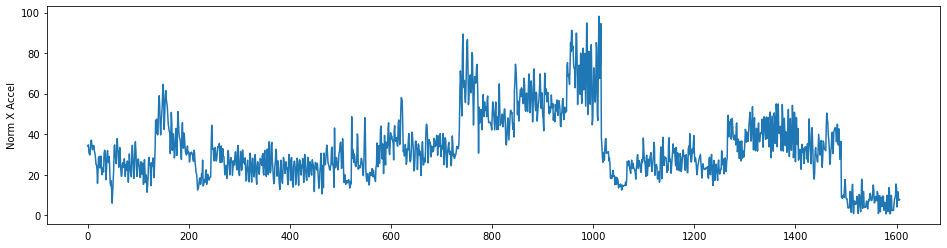

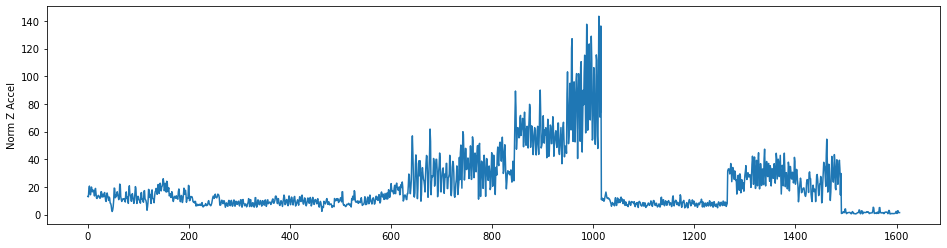

In [81]:
# plot selected features of combined datasets 
feats_to_plot = ['Norm X Accel', 'Norm Z Accel']
for feat in feats_to_plot:
    plt.figure(figsize = (16,4))
    plt.plot(time_feats[feat])
    plt.ylabel(feat)
    plt.show()

Note: More rows of exracted feature data are lost than transform features

## Part 9 - Visualized mean and std of all columns of all datasets and  for all terrains

### Time feature dataframes

In [82]:
def plt_mean_std(dataset, freq = False):
    
    dataset_mean = pd.DataFrame(columns=dataset.columns)
    dataset_std = pd.DataFrame(columns=dataset.columns)

    x = np.linspace(0,7,8)

    for i in range(len(terrains)+1): 
        dataset_mean = dataset_mean.append(dataset.loc[dataset['Label'] == i].mean(), ignore_index = True)
        dataset_std = dataset_std.append(dataset.loc[dataset['Label'] == i].std(), ignore_index = True)

    if freq:
        ncol = 4
    else:
        ncol = 7
        
    nrow = int((len(dataset_mean.columns)-2)/ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(50,40), constrained_layout = True)
    
    # to remove unused columns (label & label_IO)
    k = 2

    for i in range(nrow):
        for j in range(ncol):
            ax[i, j].scatter(x,dataset_mean[dataset_mean.columns[k]])
            ax[i, j].errorbar(x,dataset_mean[dataset_mean.columns[k]], yerr = dataset_std[dataset_mean.columns[k]].to_numpy(), fmt='none')
            ax[i, j].set_title(dataset_mean.columns[k], fontsize = 30)
            k +=1

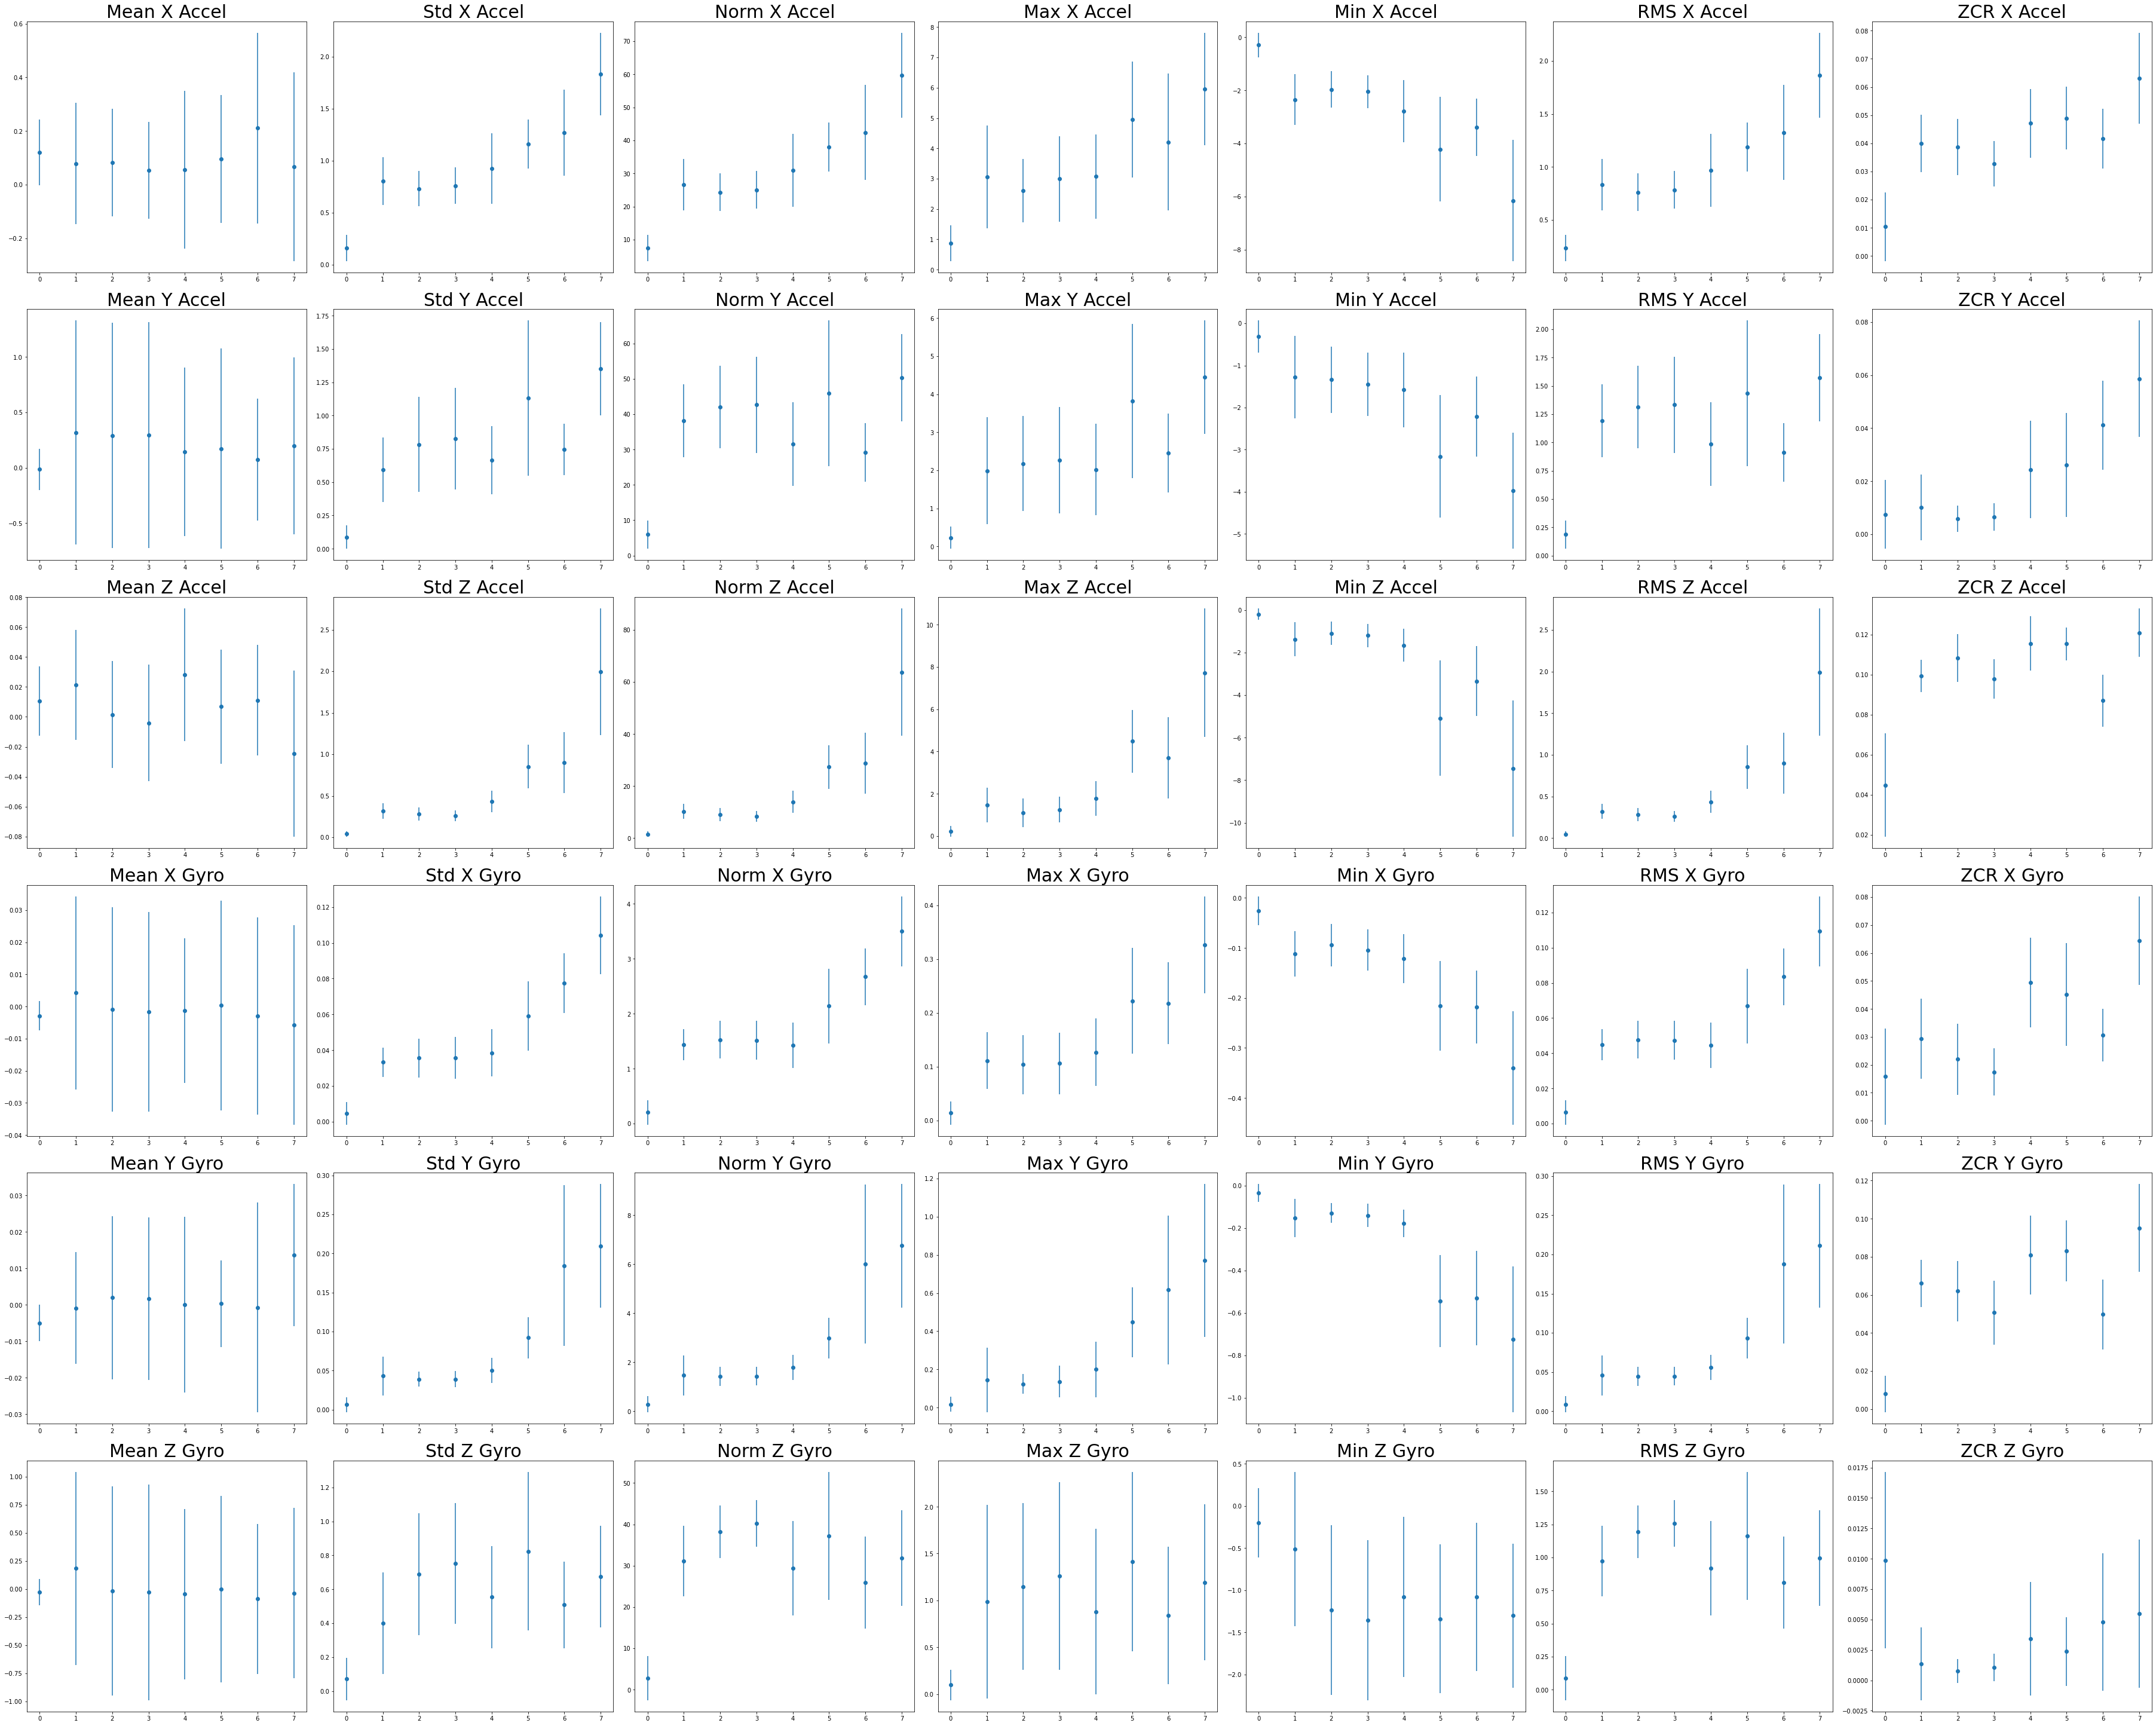

In [83]:
plt_mean_std(time_feats)

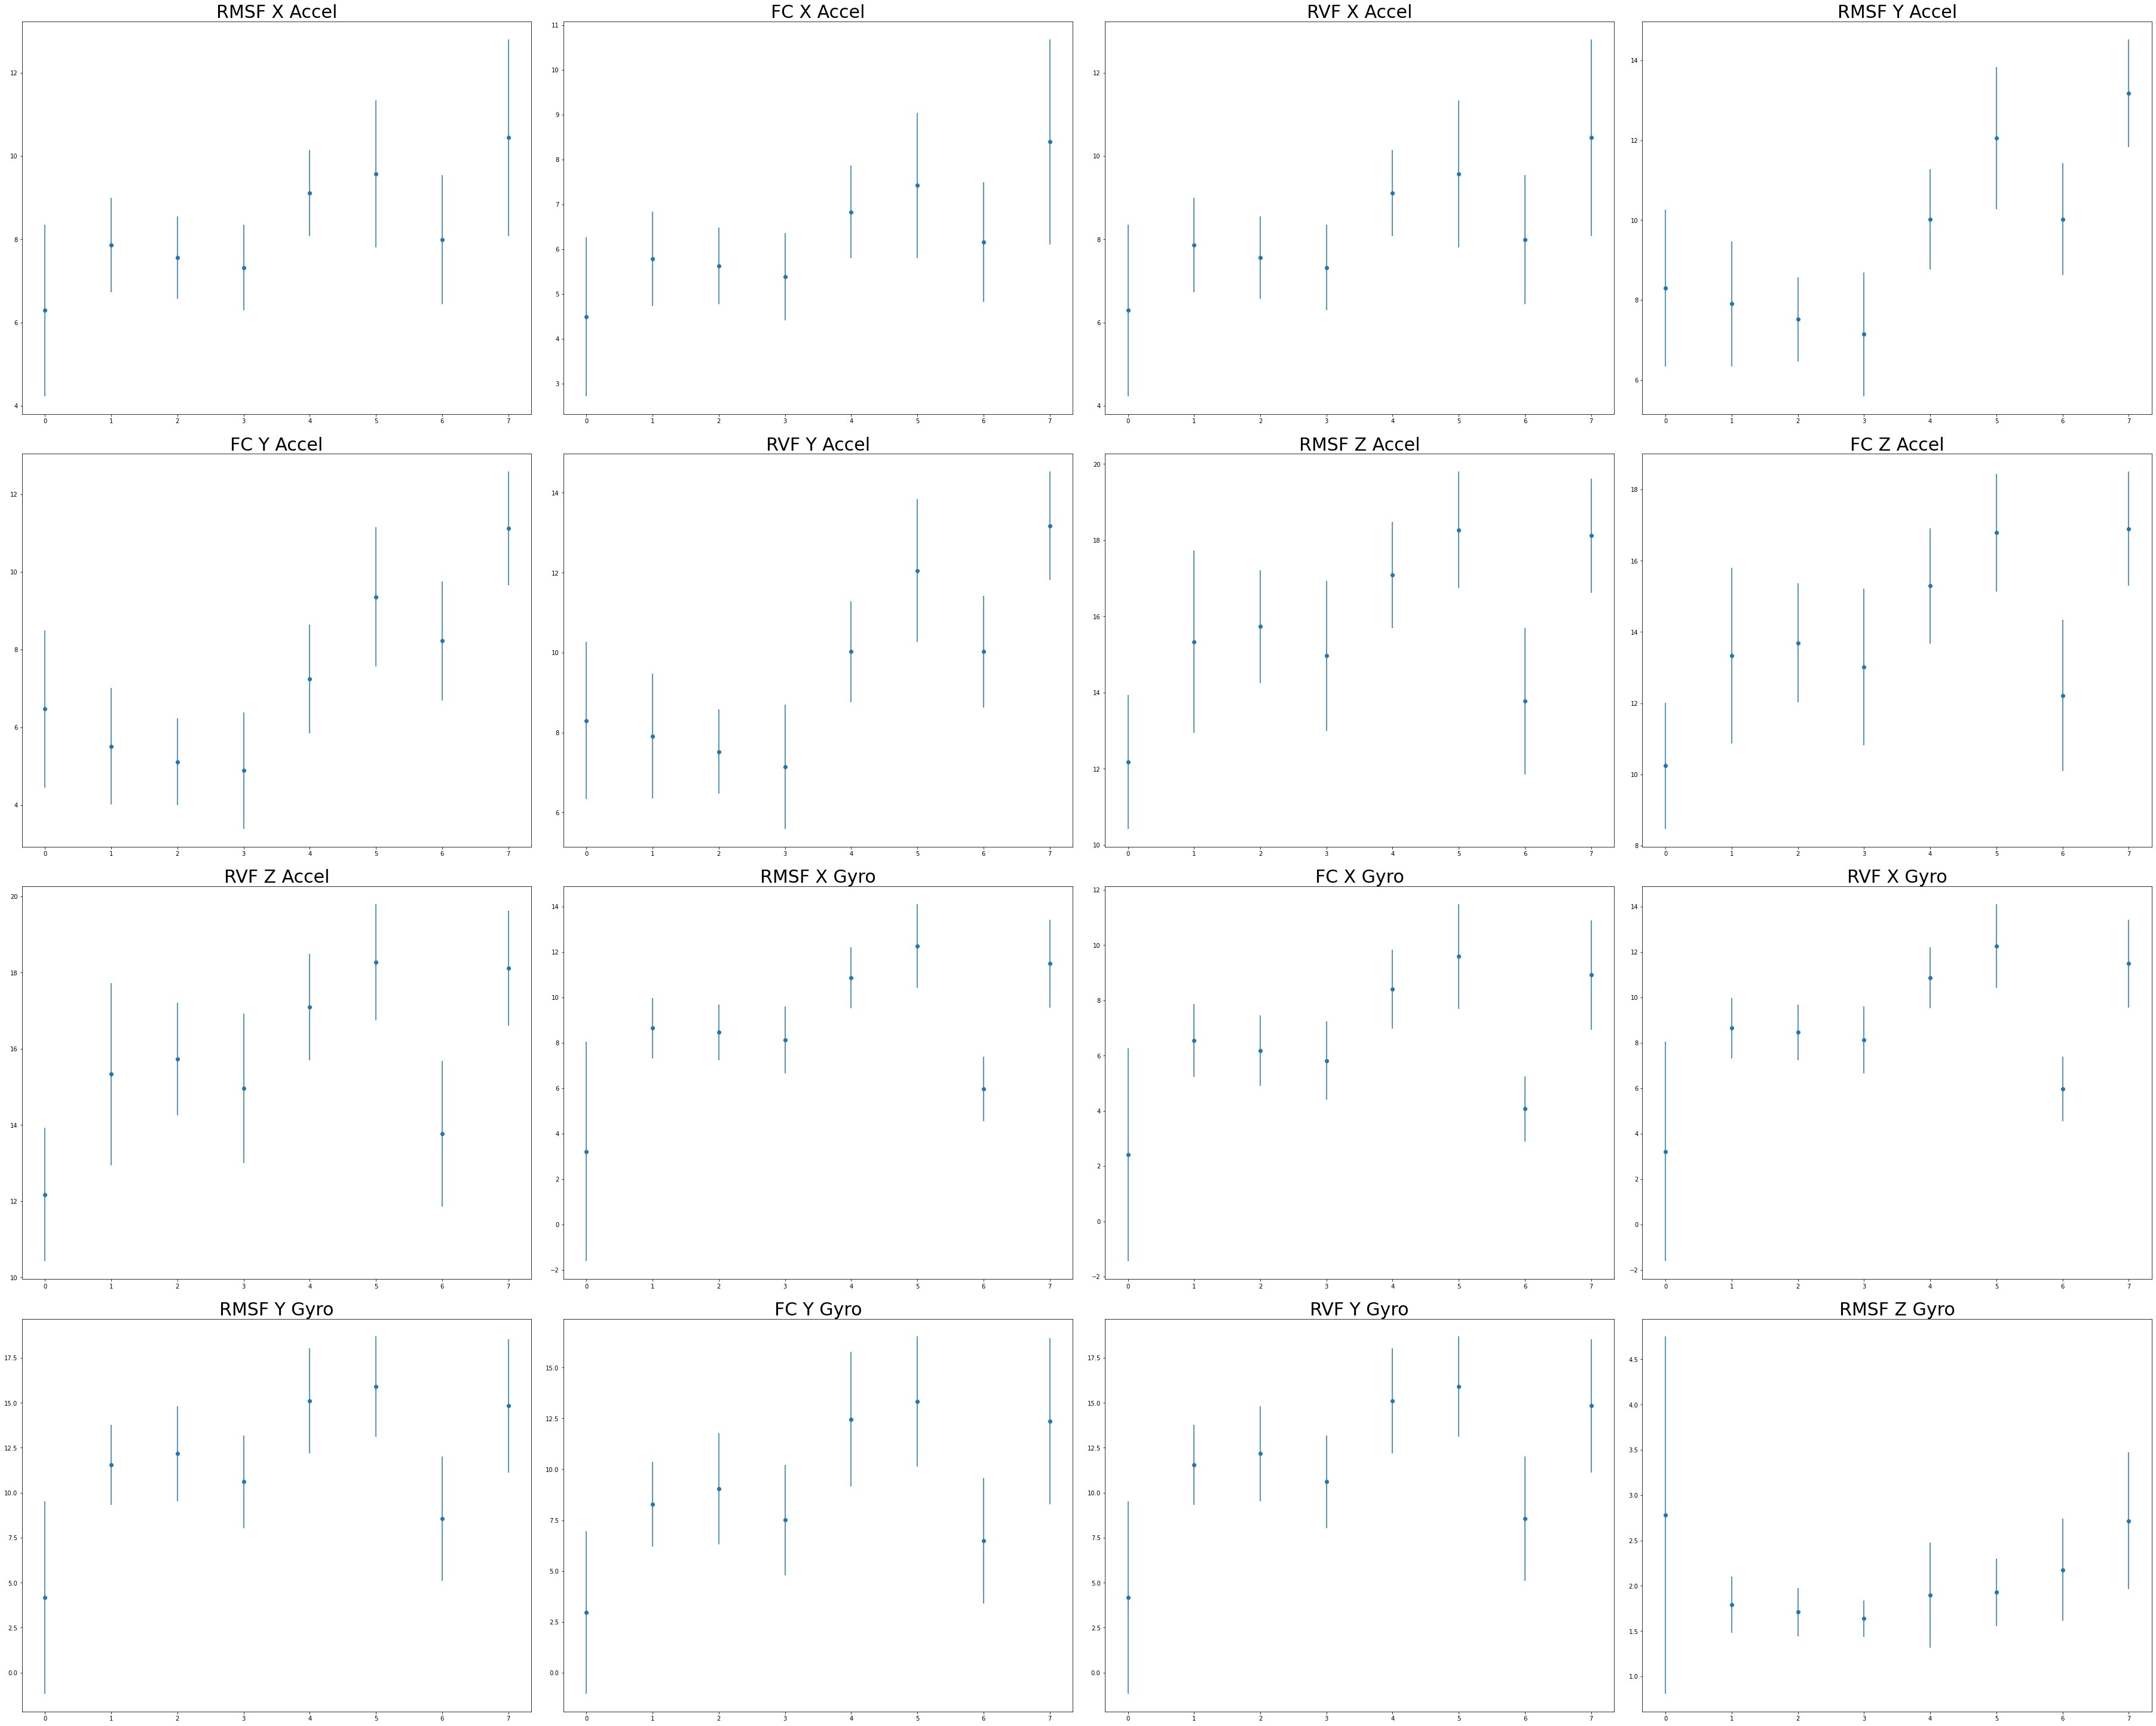

In [84]:
plt_mean_std(freq_feats, freq = True)

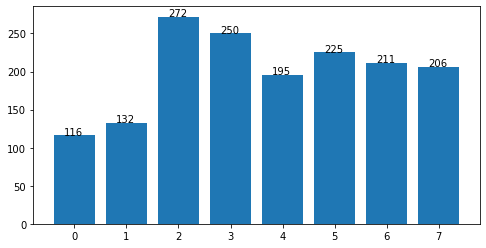

In [85]:
# number of datapoints for each terrain/ motion-state
x = np.linspace(0,7,8)
fig, ax = plt.subplots(figsize = (8,4))
y = time_feats['Label'].value_counts().sort_index()
ax.bar(x, y)
for i, value in enumerate(y):
    plt.text(i-0.2,value+1, str(value))
plt.show()

## Part 10 - Computational performance analysis

In [86]:
def latency_analysis(time_window, TIME, FREQ, FFT, PSD):
    
    ''' function to estimate computational time of pre-processing each time window '''
    
    # number of sample points in each window
    N = SAMP_SLICE
    
    def filt_(window):
        # filtering signal
        f_samp = f_samp_6050 # Sampling frequency
        f_low = CUT_OFF # a list of cutoff frequency starting at 20Hz
        f_high = 1 # High pass cutoaff frequency

        # Nyquist frequecy
        nyq = 0.5 * f_samp 

        # Get normalized frequencies 
        w_low = f_low / nyq 

        # Get Butterworth filter parameters (numerator and denominator)
        ## The function sosfiltfilt (and filter design using output='sos') should be preferred over filtfilt for most 
        ## filtering tasks, as second-order sections have fewer numerical problems.
        sos = butter(N=2, Wn=w_low, btype='low', output='sos')

        # Number of columns containing data
        n_data_col = 6

        # Filter all the data columns
        filt_window = np.copy(window)

        for i in range(n_data_col):

            # Apply a digital filter forward and backward to a signal.
            ## The combined filter (filtfilt) has zero phase and a filter order twice that of the original.
            filt_window[:, i] = sosfiltfilt(sos, filt_window[:, i])   

        window_ = pd.DataFrame(data = filt_window, columns = data_columns)

        return window_
    
    # filter
    filt_window = filt_(time_window)
    
    if FREQ or FFT or PSD:

        def windowed_(window):

            # create hanning window
            win = np.hanning(512)

            # multiply han window & data segments
            window_ = window * win[:,None]

            return window_
        
        # windowed
        windowed_window = windowed_(filt_window)
    
    if FFT:
        def fft_(window):

            # sample spacing
            T = 1/f_samp_6050

            # Frequency bin centers
            xf = fftfreq(N,T)[:N//2]

            # create an emtpy dataframe
            fft_df = pd.DataFrame(columns=data_columns)

            # calculate fft of each time window 
            for i, column in enumerate(data_columns):

                # calculate fft of each column
                y = fft(window[column].values)
                yf = 2.0/N * abs(y[0:N//2]) # keeping positive frequencies

                # add fft'd signal to a dataframe
                fft_df[column] = yf

            # Append the frequency column
            fft_df['frequency'] = xf

            fft_df = fft_df[fft_df['frequency'] <= CUT_OFF + 10]

            return(fft_df)
        
        # fft
        fft_window = fft_(windowed_window)
    
    if PSD or FREQ:
        def psd_(window):

            psd_datasets = {}

            # sampling frequency
            fs = f_samp_6050    

            # create an emtpy dataframe
            psd_df = pd.DataFrame(columns=data_columns)

            # calculate psd of each time window 
            for i, column in enumerate(data_columns):

                # calculate psd of each column
                f, Pxx_den = welch(window[column].values, fs)

                # add psd'd signal to a dataframe
                psd_df[column] = Pxx_den

            # Append the frequency column
            psd_df['frequency'] = f  

            # trim unwanted frequencies
            psd_df = psd_df[psd_df['frequency'] <= CUT_OFF + 10]

            return(psd_df)
        
        # psd
        psd_window = psd_(windowed_window)
    
    if TIME:
        def time_feature_extraction(window, features_dic):
            # will be updated with keys as data columns (e.g., 'X Accel') 
            cols_dic = {}

            window_copy = window.copy()

            # Loop over data columns
            for col in data_columns:

                # will be updated with keys as extracted feature names (e.g., 'Mean')
                feats = {}

                def function_all_windows(function):

                    featured_column = function(window_copy[col])

                    return featured_column 

                # Execute every function over all windows    
                for feat_name, feat_func in features_dic.items():

                    # apply feature extraction to the ith column for all windows
                    feats.update({feat_name: function_all_windows(feat_func)})


                cols_dic.update({col: pd.DataFrame(feats, index=[0])})

            return cols_dic
        
        # time feature extraction
        time_featured_window = time_feature_extraction(filt_window, time_features)
    
    if FREQ:
        def freq_feature_extraction(window, features_dic):
            # will be updated with keys as data columns (e.g., 'X Accel') 
            cols_dic = {}

            window_copy = window.copy()

            # Loop over data columns
            for col in data_columns:

                # will be updated with keys as extracted feature names (e.g., 'Mean')
                feats = {}

                def function_all_windows(function):

                    featured_column = function(window_copy.iloc[:, -1], window_copy[col])

                    return featured_column 

                # Execute every function over all windows    
                for feat_name, feat_func in features_dic.items():

                    # apply feature extraction to the ith column for all windows
                    feats.update({feat_name: function_all_windows(feat_func)})


                cols_dic.update({col: pd.DataFrame(feats, index=[0])})

            return cols_dic
        
        # frequency feature extraction
        freq_featured_window = freq_feature_extraction(psd_window, freq_features)
    
    if TIME or FREQ:
        def combine_extracted_columns_window(window_dic):

            def append_all_columns(columns, append_tag):
                new_columns = []

                for column in columns:
                    if append_tag not in column:
                        new_columns.append(column + ' ' + append_tag)
                    else:
                        new_columns.append(column)

                return new_columns

            # Get labels array of first column
            df_combined = pd.DataFrame()

            # Append direction name to feature name and combine everything in one frame
            for col_label, df in window_dic.items():
                df_copy = pd.DataFrame(df)

                # Add direction and placement tags
                df_copy.columns = append_all_columns(df.columns, col_label)

                df_combined = df_combined.join(df, how='outer')

            return df_combined
        
        if TIME:
            # columbing
            columned_time_feats = combine_extracted_columns_window(time_featured_window)
        else:
            columned_freq_feats = combine_extracted_columns_window(freq_featured_window)
    
    if FFT or PSD:
        def combine_transform_columns(window, trans = ''):

            window_copy = window.copy()

            # Get frequency bins from frequency column of first window
            freq_bins = window['frequency'].tolist()

            # Get more parameter for current label
            trans = trans

            # Combine parameters to form columns for new combined DataFrame
            new_cols = [trans + ' {} Hz '.format(round(f_bin, 1)) + d_col for d_col in data_columns for f_bin in freq_bins]

            # Convert windowed arrays into a single array with each window as a row
            new_data = []

            new_row = []
            for d_col in data_columns:
                new_row.extend(window_copy[d_col].tolist())
            new_data.append(new_row)

            # Create new DataFrame
            df_combined = pd.DataFrame(data=new_data, columns=new_cols)

            return df_combined
        
        if FFT:
            # combine fft
            columned_fft_window = combine_transform_columns(fft_window, 'FFT')
        else:
            # combine psd
            columned_psd_window = combine_transform_columns(psd_window, 'PSD')
    
#   columned_fft_window
#   columned_psd_window
#   columned_freq_feats
#   columned_freq_feats
    return()

In [87]:
# create a test window
test_window = raw_datasets[dataset_labels[0]][:512][data_columns]

# determine which feature sets should be created
TIME = True
FREQ = True
FFT = True
PSD = True

# method 1
%timeit transformed_window = latency_analysis(test_window, TIME, FREQ, FFT, PSD)

# method 2
time1 = time.time()
transformed_window = latency_analysis(test_window, TIME, FREQ, FFT, PSD)
time2 = time.time()
print('data preparation time: {} ms'.format((time2-time1)*1000))

# check output
transformed_window

82.9 ms ± 8.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
data preparation time: 70.95980644226074 ms


()

## Part 10 - Exporting Processed Data 

In [88]:
# Processed data path with power type folder
processed_path = os.path.join(CURR_PATH, 'processed_data')

# Store feature vectors in a dictionary
vector_dict = {'TimeFeats': time_feats, 'FreqFeats': freq_feats, 'FFTs': ffts, 'PSDs': psds}

# Set in notebook parameters at top of notebook
if EXPORT_PROCESSED_DATA:
    
    # Save each vector and each placement to .csv file
    for vector_name, vector_data in vector_dict.items():
        
        # Filename using above dictionary         
            filename = os.path.join(processed_path, vector_name + '.csv')
            vector_data.to_csv(filename, index=False)